In [1]:
import scipy.stats as stats

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from swissgrid import grid_data as gd
import numpy as np
from sklearn.linear_model import LinearRegression

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import api as sm

In [4]:
total_consumption = gd.iloc[:,2]

In [5]:
consw = total_consumption.resample('W').sum()[1:-1] #discard first and last because incomplete

In [6]:
weather = pd.read_csv('data/weather_data_filtered.csv')
weather['timestamp'] = pd.to_datetime(weather['utc_timestamp'])
weather = weather[['timestamp', 'CH_temperature']].set_index('timestamp').sort_index()
weather = weather.tz_localize(None)

#align weather and consumption indexes
w = weather.resample('W').mean()[consw.index[0]:]
c = consw[:w.index[-1]]/1e6 #unit of measurement is now GWh

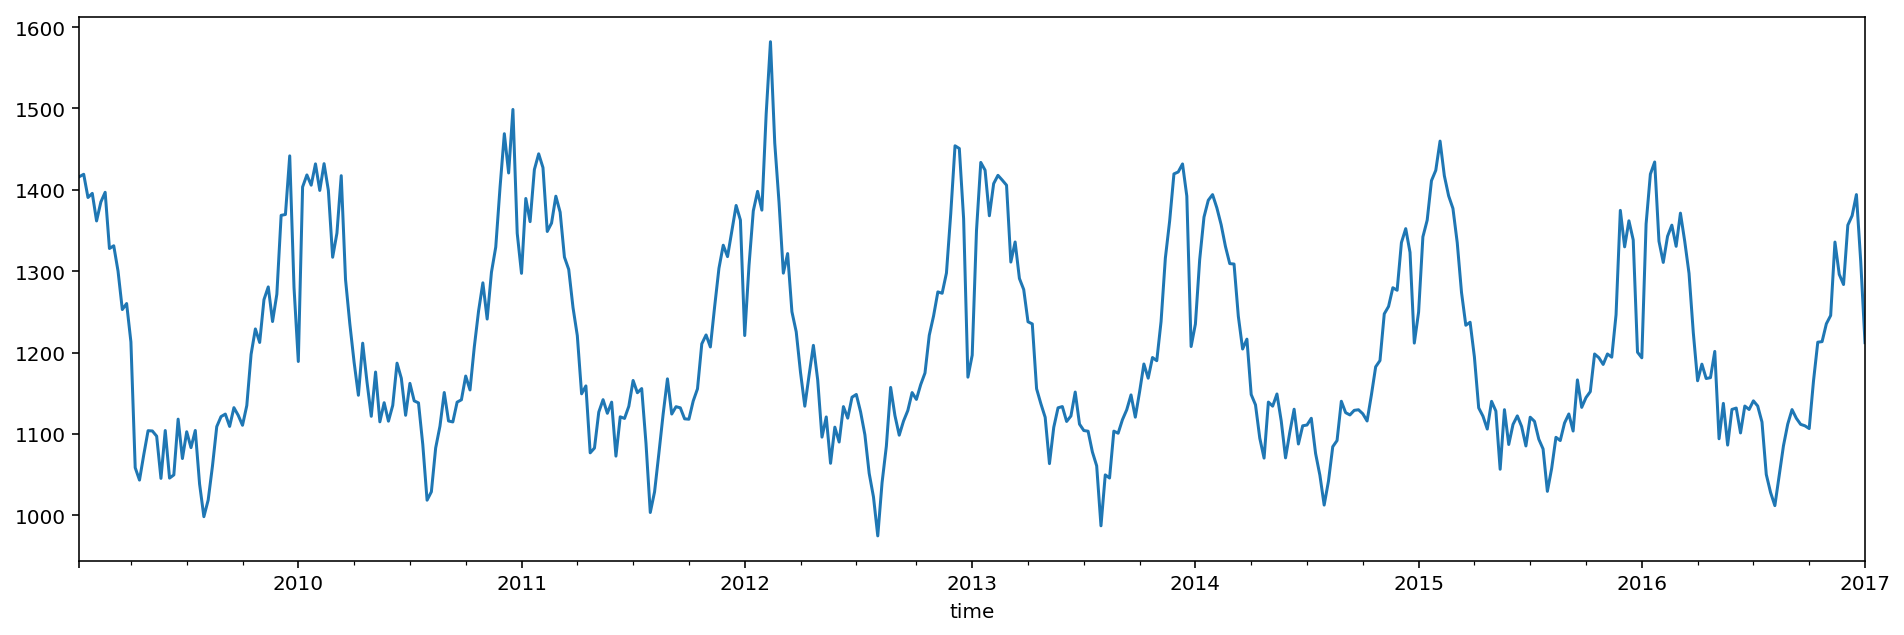

In [7]:
c.plot()

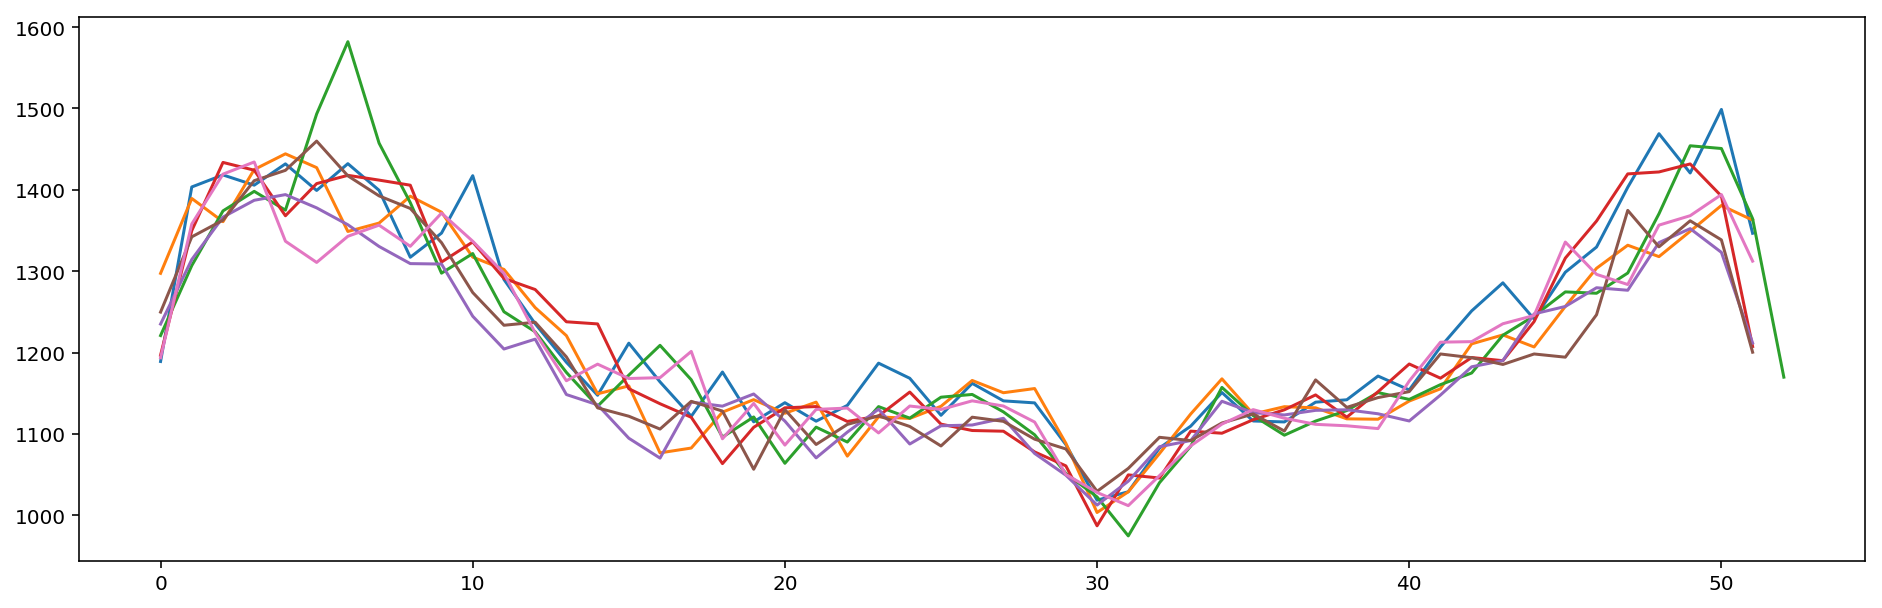

In [8]:
[plt.plot(c[str(year)].values) for year in range(2010,2017)];

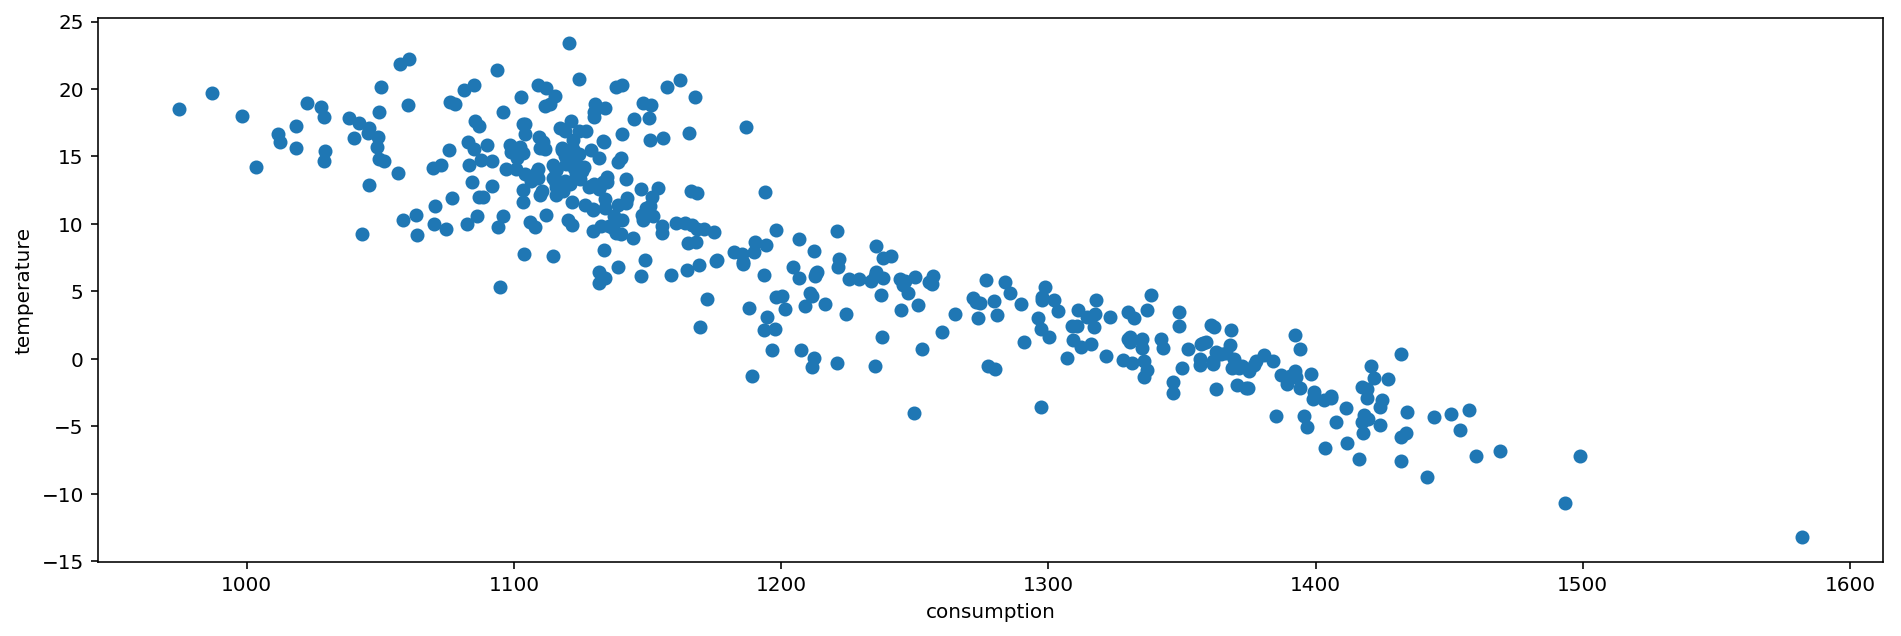

In [9]:
plt.scatter(c, w)
plt.xlabel('consumption')
plt.ylabel('temperature');

In [10]:
weather_model = LinearRegression().fit(w.values.reshape(-1,1), c.values.reshape(-1,1))

In [11]:
est_weather = pd.Series(data=weather_model.predict(w.values.reshape(-1,1)).flatten(), index=w.index)

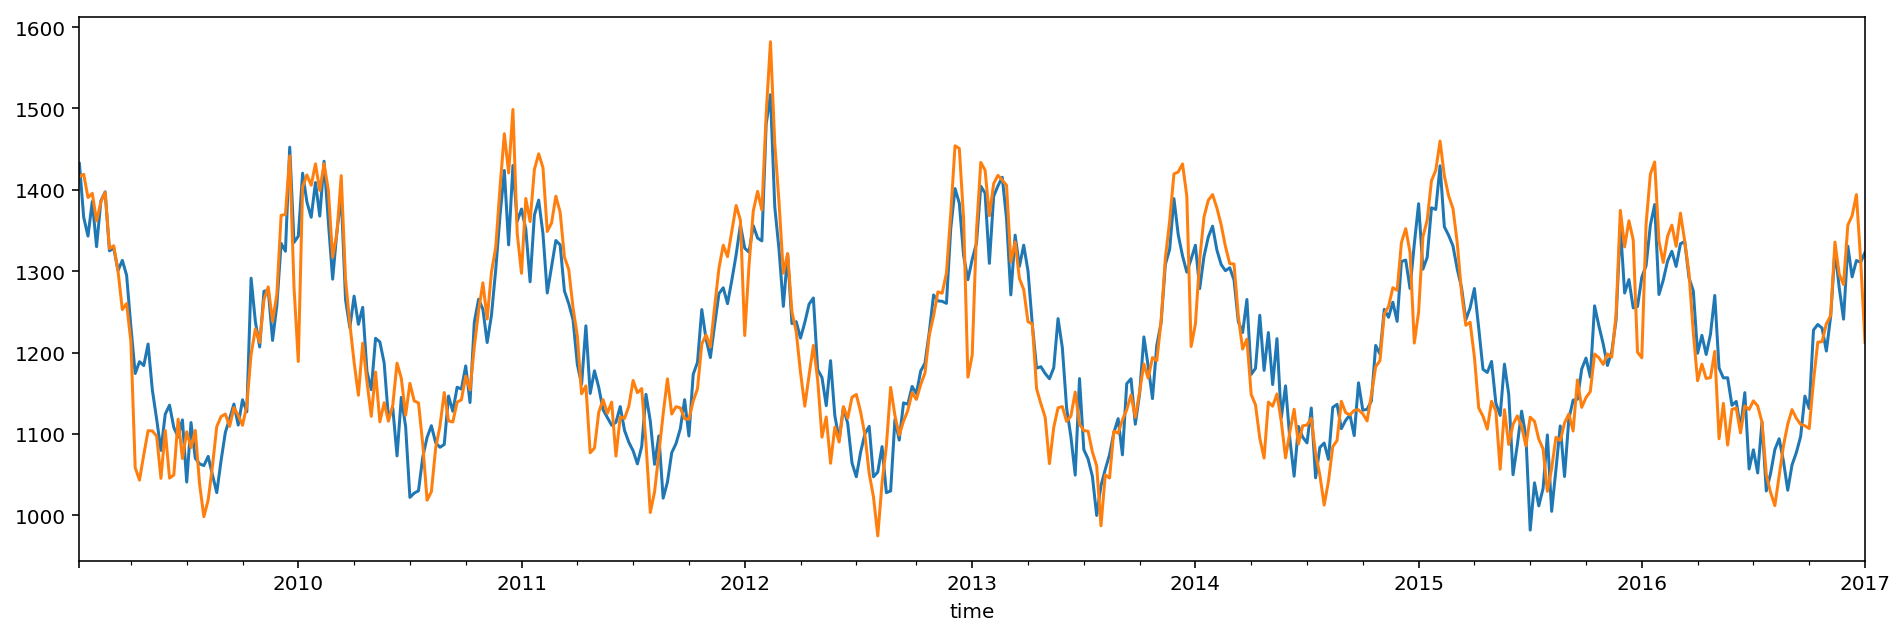

In [12]:
est_weather.plot()
c.plot()

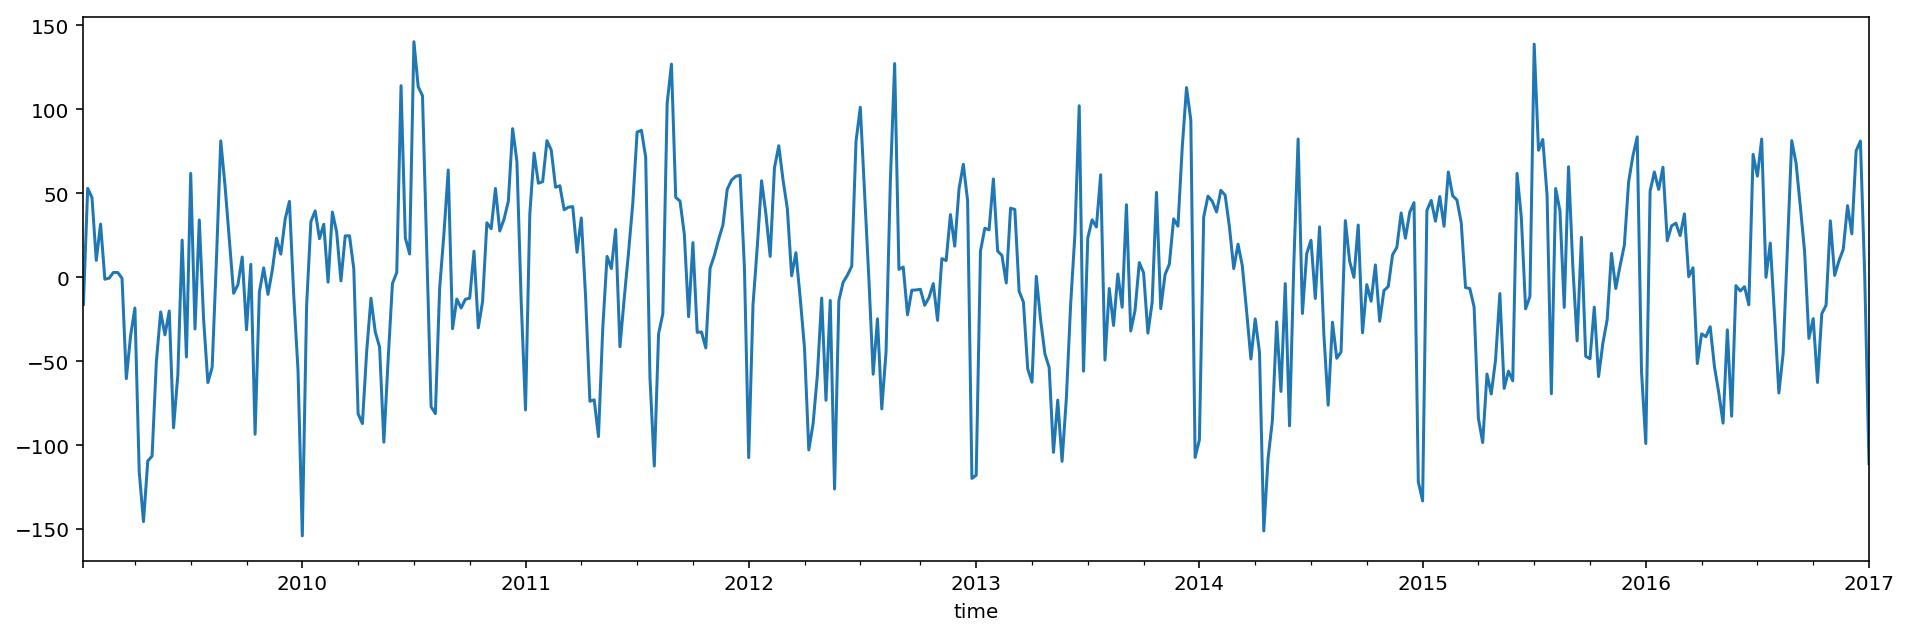

In [13]:
residual_weather = c - est_weather
residual_weather.plot()

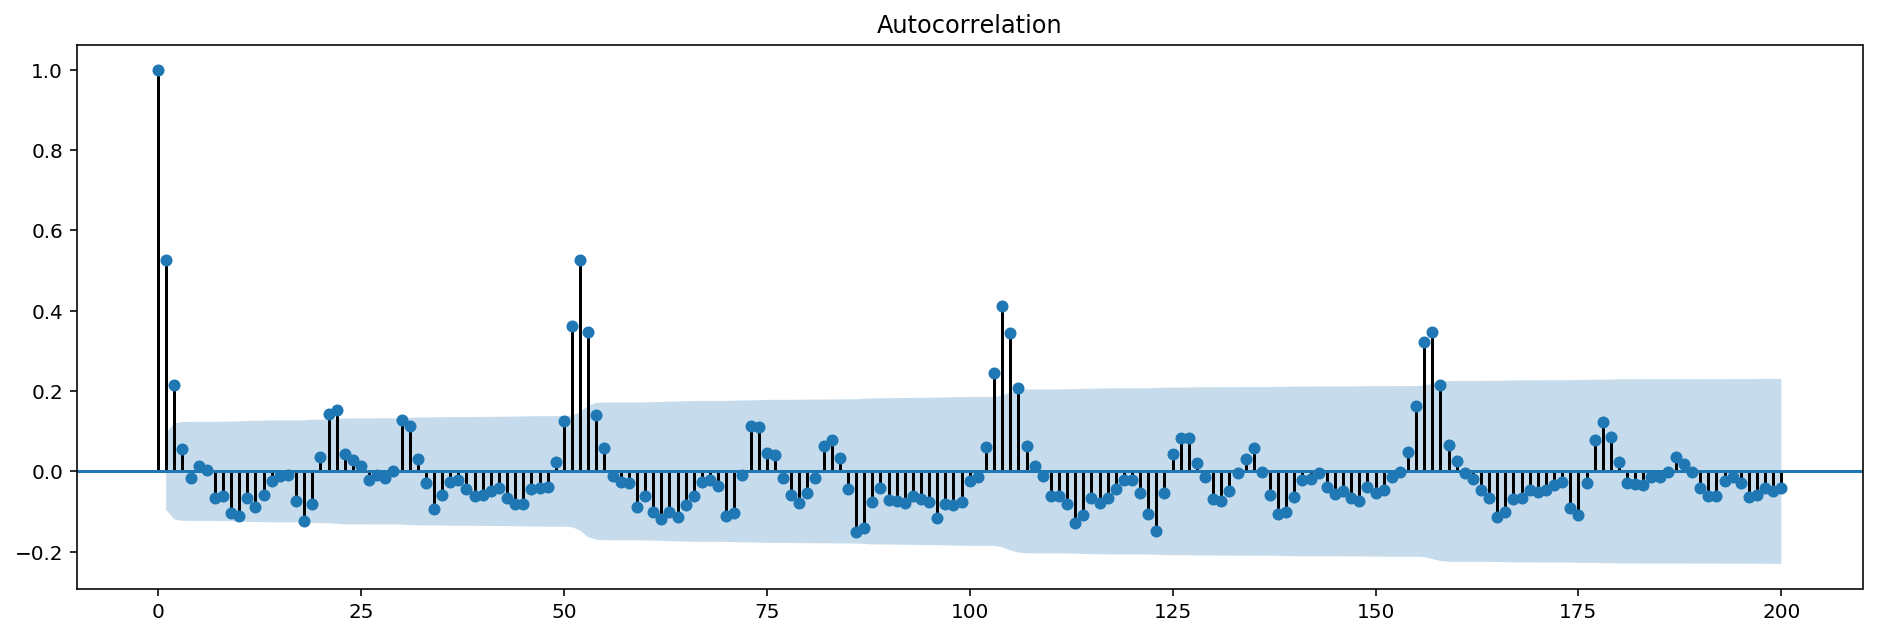

In [14]:
plot_acf(residual_weather,lags=200);

# Introducing Holidays covariates

In [1]:
import holidays

ModuleNotFoundError: No module named 'holidays'

In [16]:
holidays_ch = holidays.Switzerland()
days = total_consumption.resample('D').sum().index
is_holy = [day in holidays_ch for day in days]
holys = pd.DataFrame(is_holy, days, columns=['is_holiday'])

# regress residuals on additional variable which counts the swiss festivities per week
h_reg = (holys['is_holiday']*1).resample('W').sum()[residual_weather.index[0]:residual_weather.index[-1]]

In [17]:
holiday_crude_model = LinearRegression().fit(h_reg.values.reshape(-1,1), residual_weather.values.reshape(-1,1))

In [18]:
est_holiday_crude = pd.Series(data=holiday_crude_model.predict(h_reg.values[...,None]).flatten(), index=h_reg.index)
res_holiday_crude = (residual_weather - est_holiday_crude)

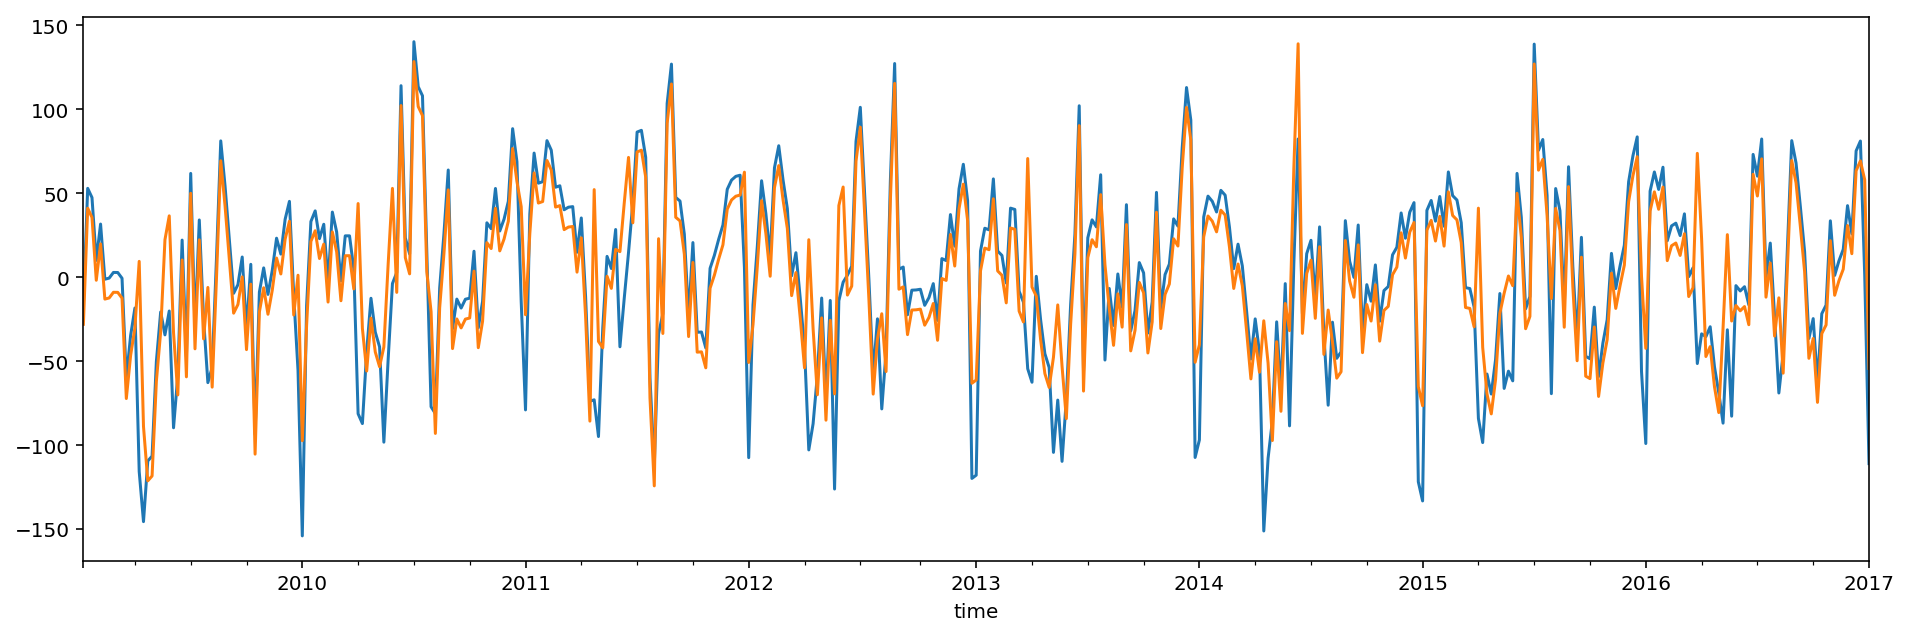

In [19]:
residual_weather.plot()
res_holiday_crude.plot()

In [20]:
(residual_weather**2).mean() #MSE of regression on weather

2804.450767727304

In [21]:
(res_holiday_crude**2).mean() # MSE after controlling for holidays

1954.1578830819863

### Finer holiday counting

Let's define a covariate that counts canton per canton the number of residents that are on holiday, and then aggregate over all switzerland

In [22]:
def get_holy(prov):
    h = holidays.Switzerland(prov=prov)
    return [day in h for day in days]
holidays_cantons = pd.DataFrame(data = {prov:get_holy(prov) for prov in holidays.Switzerland.PROVINCES},
             index = days)
#add sundays (hurts MSE)
# holidays_cantons = (holidays_cantons.T | (holidays_cantons.index.dayofweek == 6)).T

In [23]:
cantons = pd.read_csv('data/cantons.csv').set_index('Code')
#magic trick
cantons['Population'] = cantons['Population'].str.extract('([^\[]*)').iloc[:,0].str.split(',').str.join('').astype(np.intp)

In [24]:
holiday_pop = (holidays_cantons*cantons['Population']
              ).resample(
    'W'
    ).mean().sum(1)[residual_weather.index[0]:residual_weather.index[-1]]

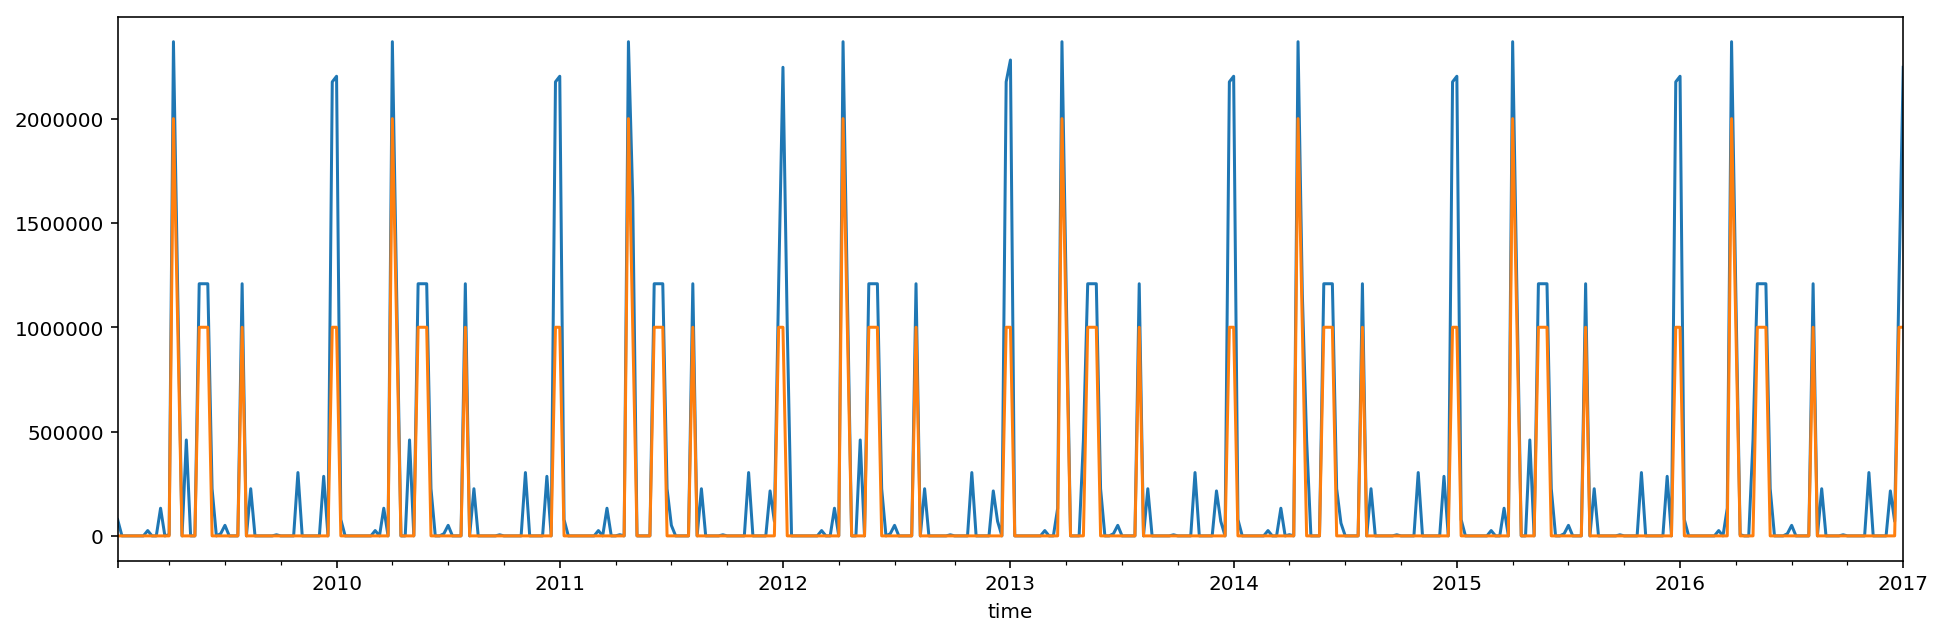

In [25]:
holiday_pop.plot()
(h_reg*1e6).plot() #rescale the crude regressor since it only counts the number of 
                    # festifities and not the total people subject

Extra days appear with this finer approach, lets check if it makes a difference

In [26]:
holiday_fine_model = LinearRegression().fit(holiday_pop.values.reshape(-1,1), residual_weather.values.reshape(-1,1))
res_holiday_fine = residual_weather - holiday_fine_model.predict(holiday_pop.values.reshape(-1,1)).flatten()

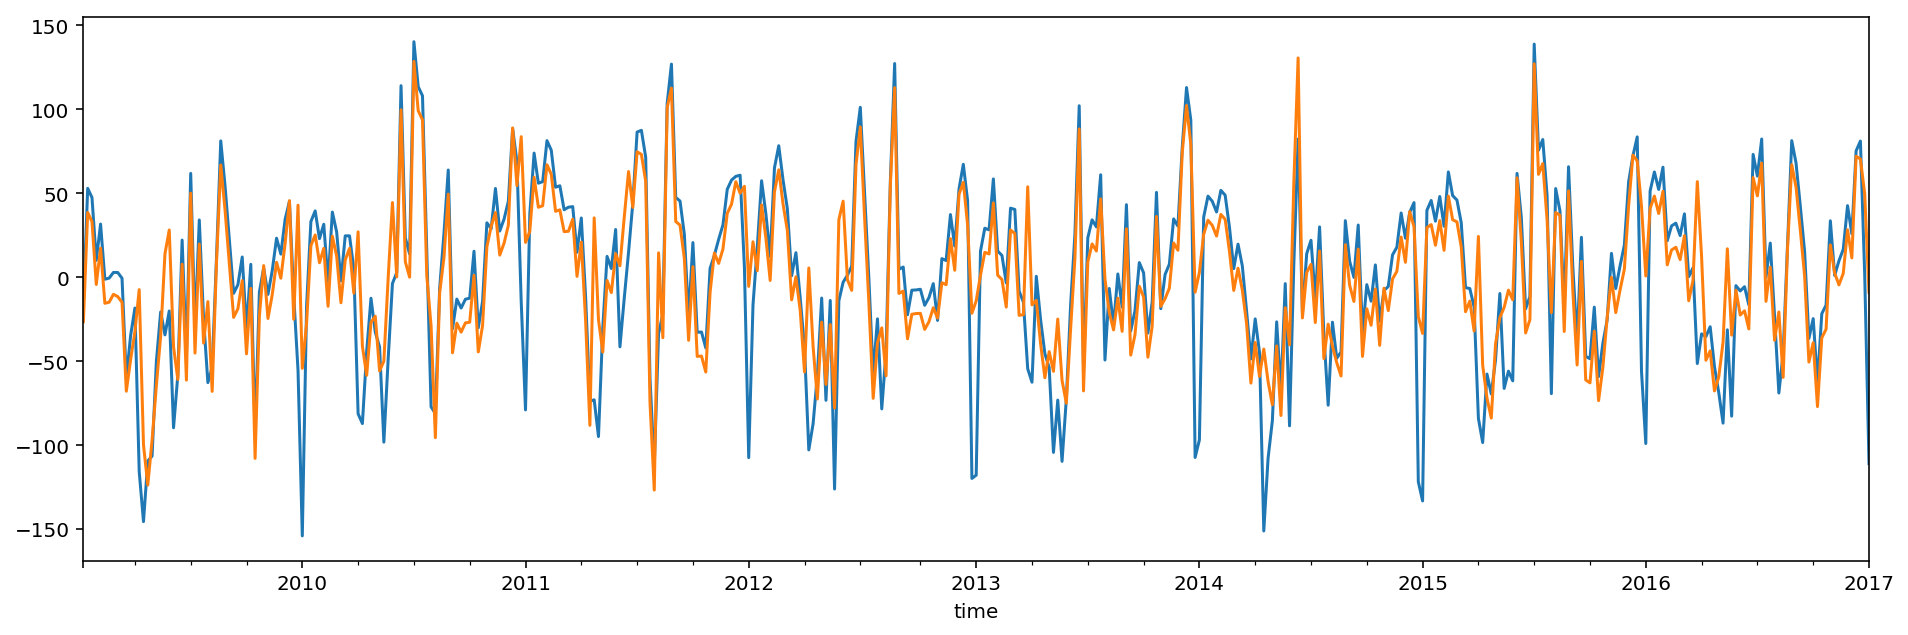

In [27]:
residual_weather.plot()
res_holiday_fine.plot()

In [28]:
(res_holiday_fine**2).mean()

1856.1445098328056

In [29]:
(res_holiday_crude**2).mean()

1954.1578830819863

MSE further decreased by a bit, with the finer counting method.

### We regressed individually on weather, and then on holidays. Now we try to do them together.

In [30]:
c # consumption in GWh
holiday_pop #people days of holiday per week
w #average temperature deviation(?) per week

data = pd.DataFrame({'temp':w['CH_temperature'], 'consumption':c, 'holidays':holiday_pop})
# data['cross'] = data['temp']*data['holidays'] cross term useless
weather_holiday_model = LinearRegression().fit(data[['temp','holidays']].values, data[['consumption']])

In [31]:
est_weather_holiday = pd.Series(weather_holiday_model.predict(data[['temp', 'holidays']].values).flatten(), data.index)

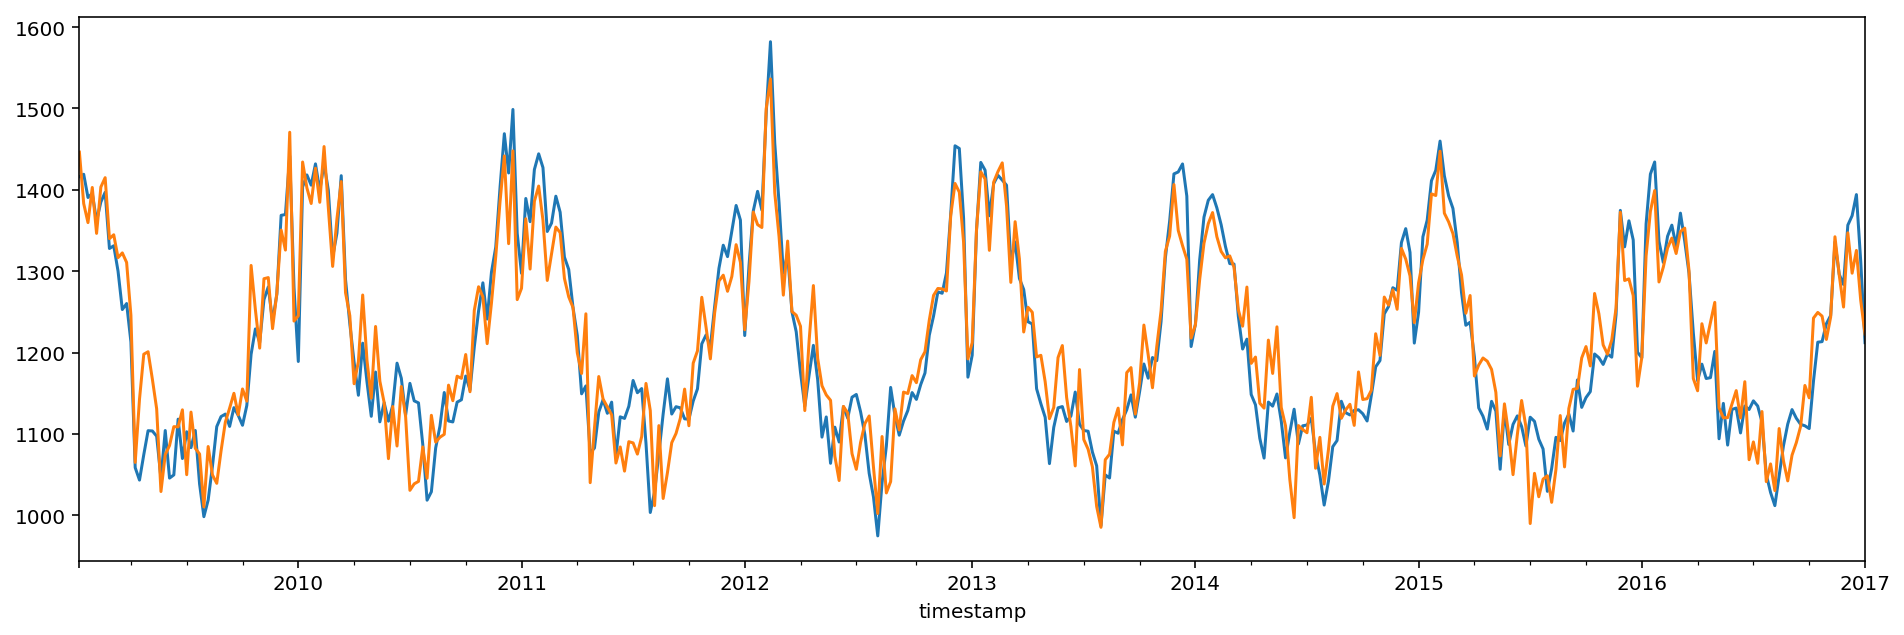

In [32]:
c.plot()
est_weather_holiday.plot()

In [33]:
res_weather_holiday = c-est_weather_holiday
(res_weather_holiday**2).mean()

1853.0028145097185

Almost the same as first regressing on weather and then on holidays

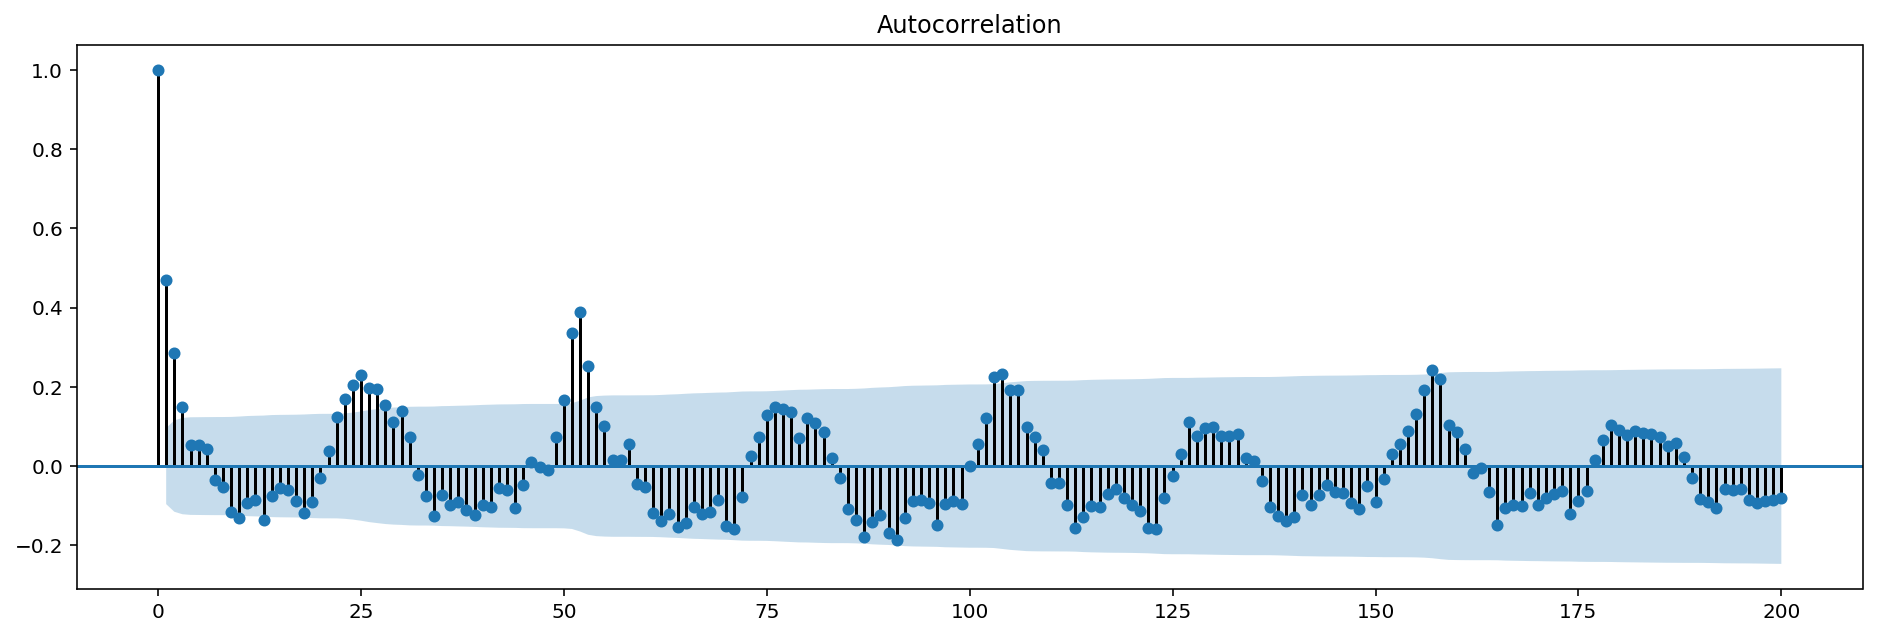

In [122]:
plot_acf(res_weather_holiday,lags=200); # what does this acf mean for residuals? definitely not stationary

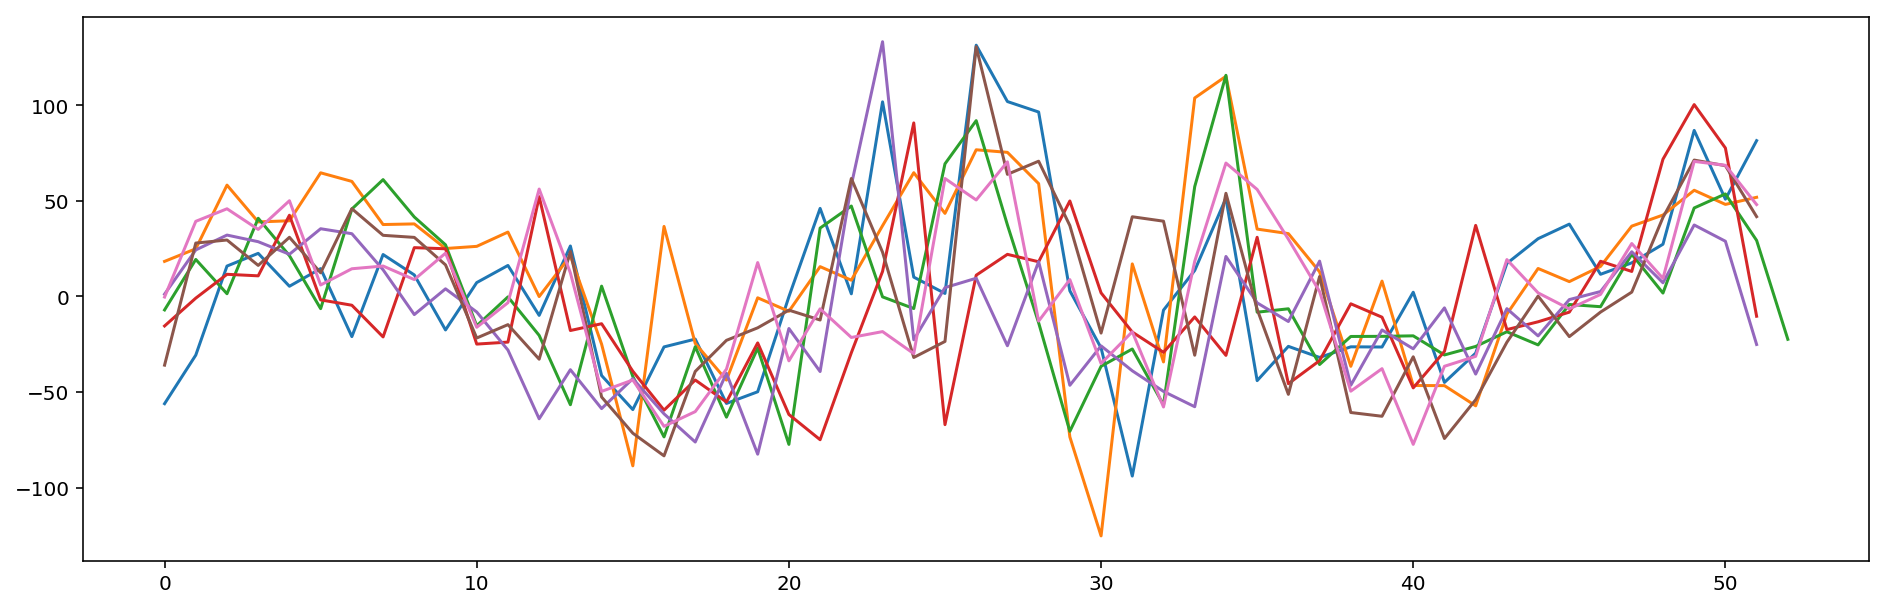

In [38]:
[plt.plot(res_weather_holiday[str(year)].values) for year in range(2010,2017)];
#error not only has variable volatility but also a trend

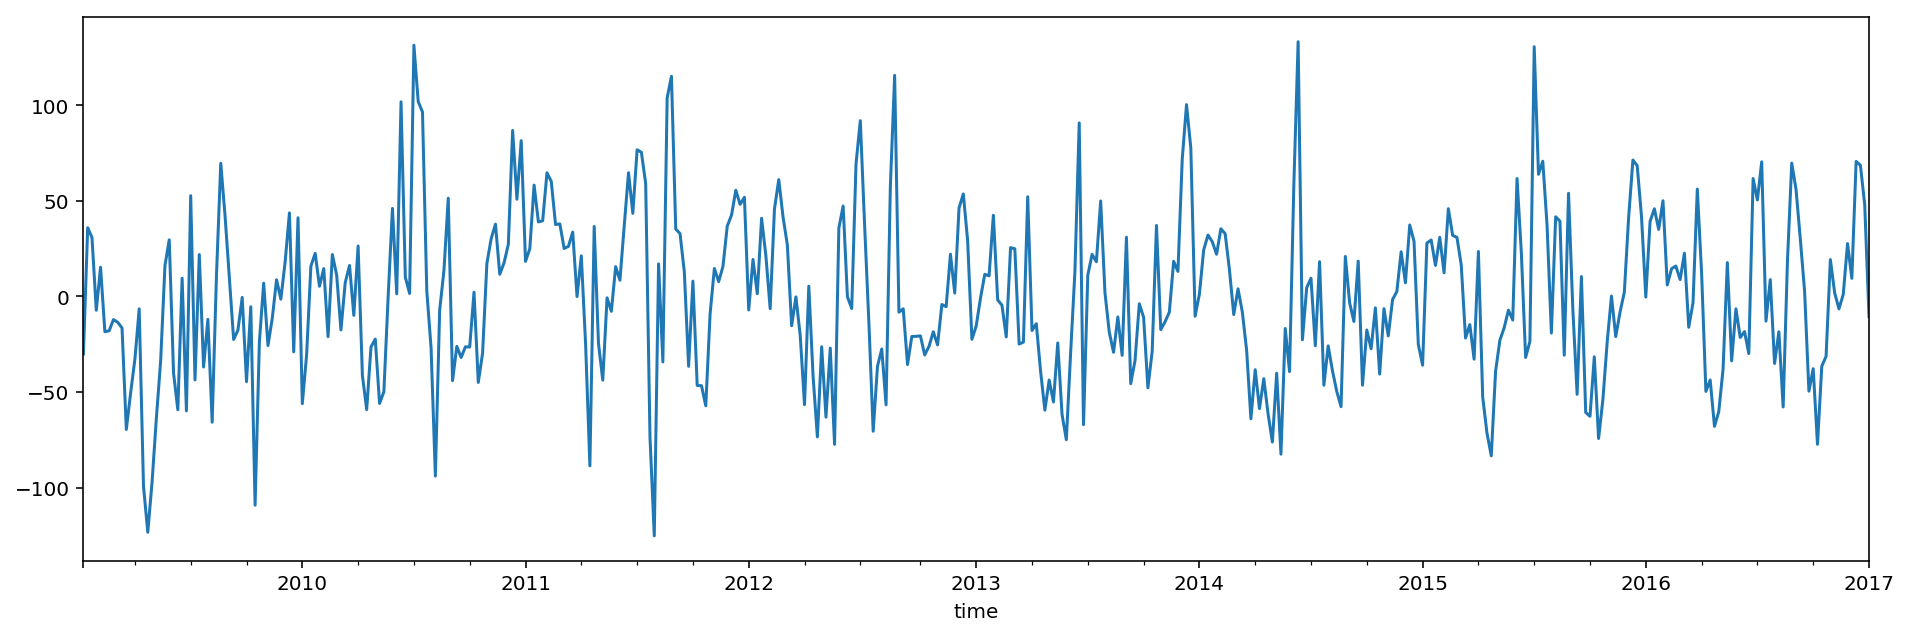

In [39]:
res_weather_holiday.plot()

## Further developments: STL on residuals / filtering on STL residuals

In [40]:
import stldecompose

In [41]:
b = stldecompose.decompose(res_weather_holiday, period=52, lo_delta=1);

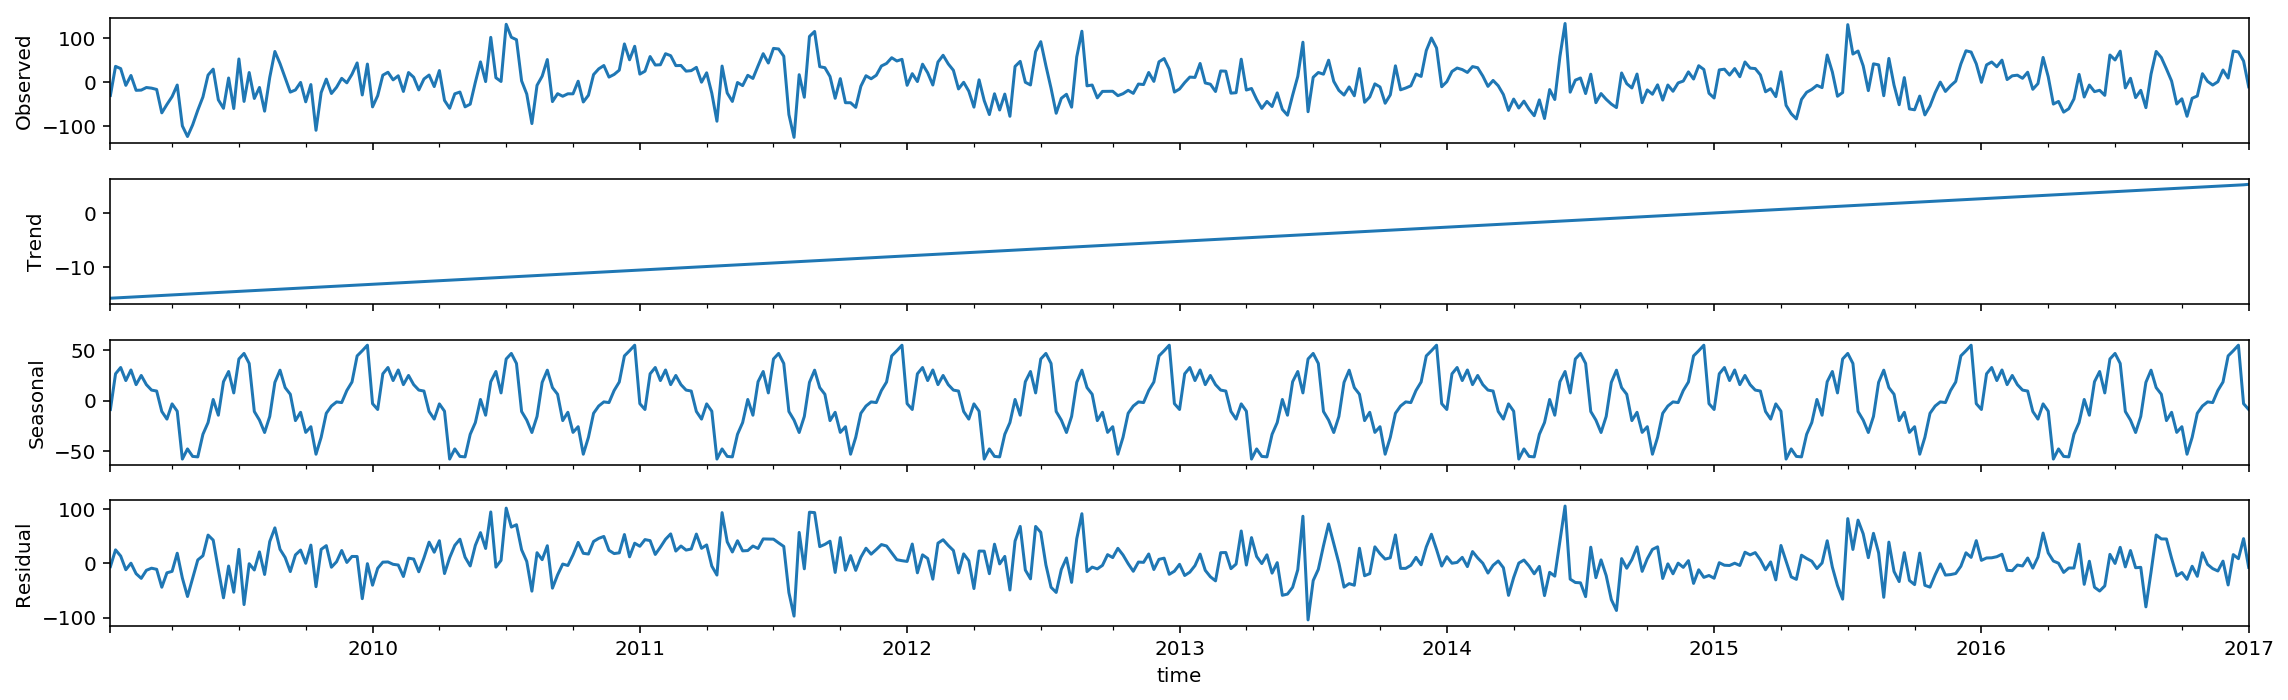

In [42]:
b.plot();

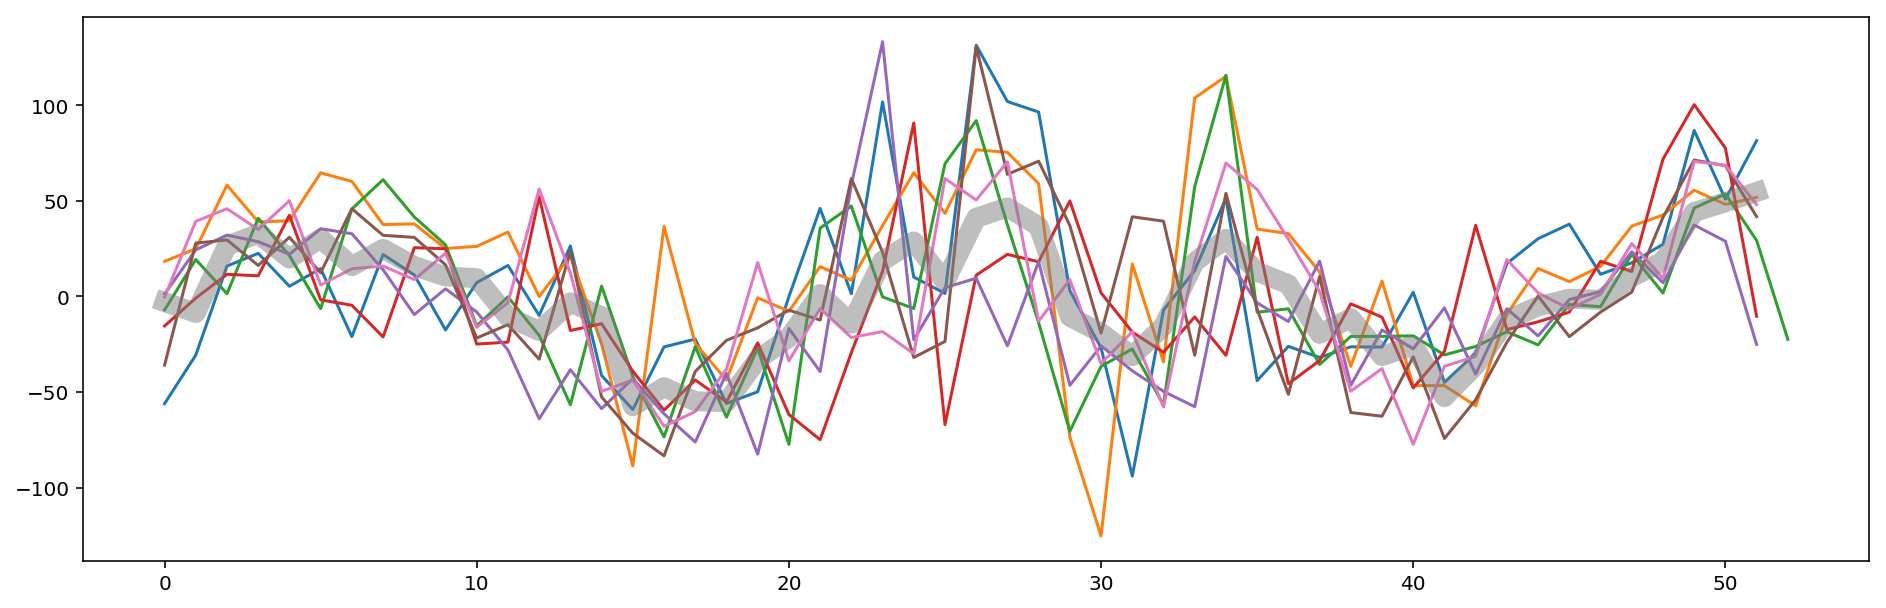

In [43]:
[plt.plot(res_weather_holiday[str(year)].values) for year in range(2010,2017)];
plt.plot(b.seasonal['2010'].values, linewidth=10, alpha=0.5)

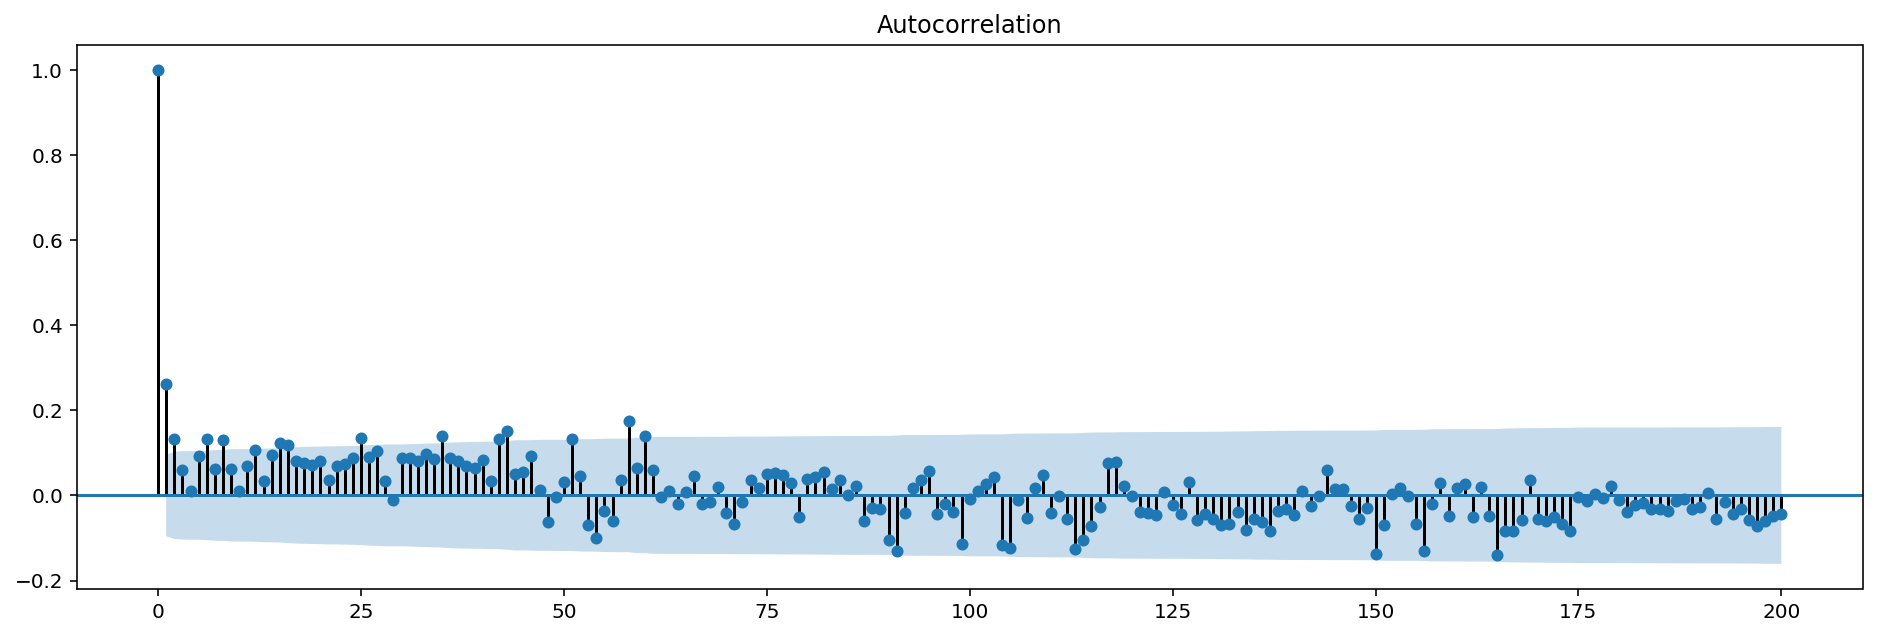

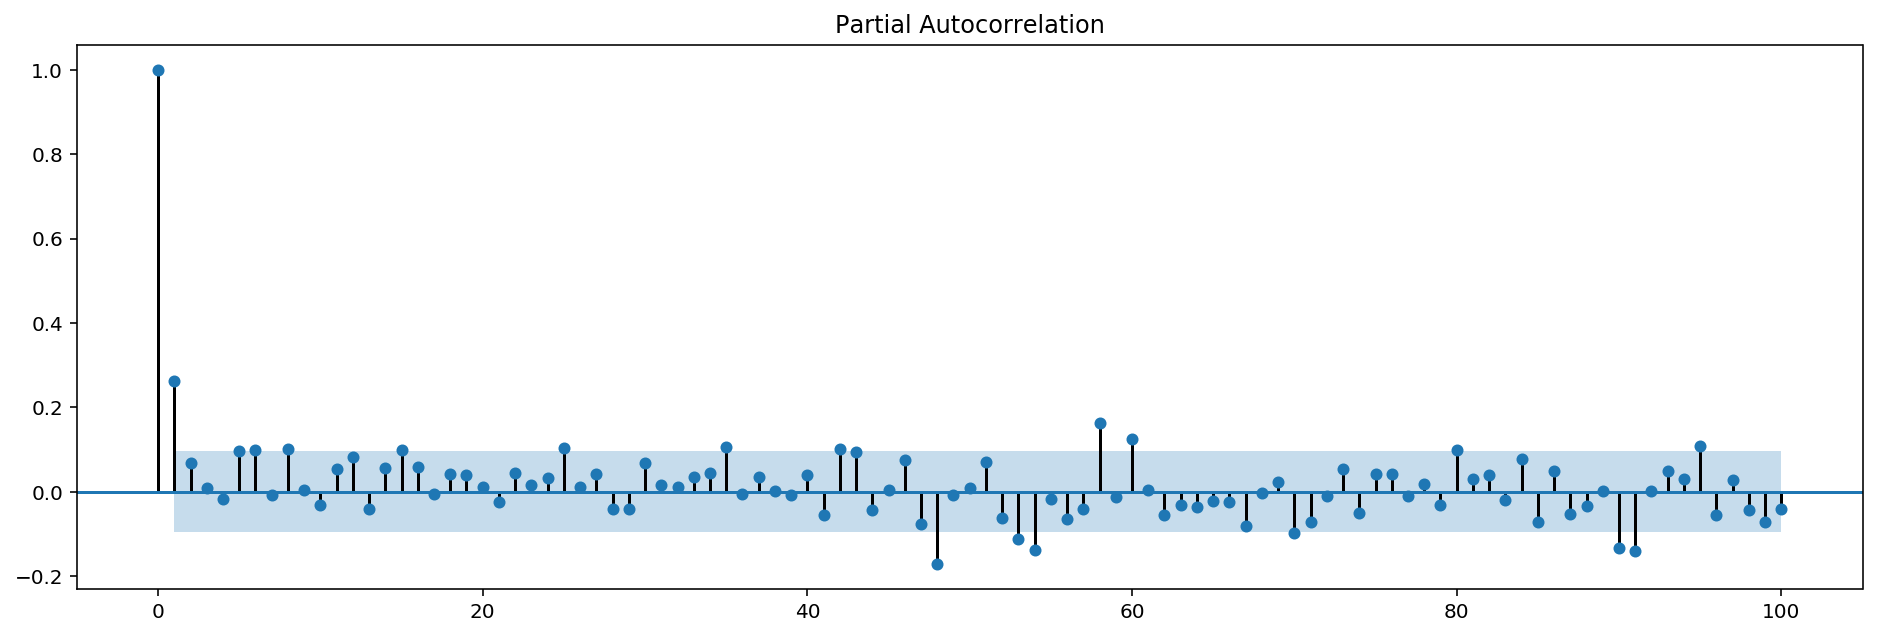

In [44]:
plot_acf(b.resid, lags=200);
plot_pacf(b.resid, lags=100);

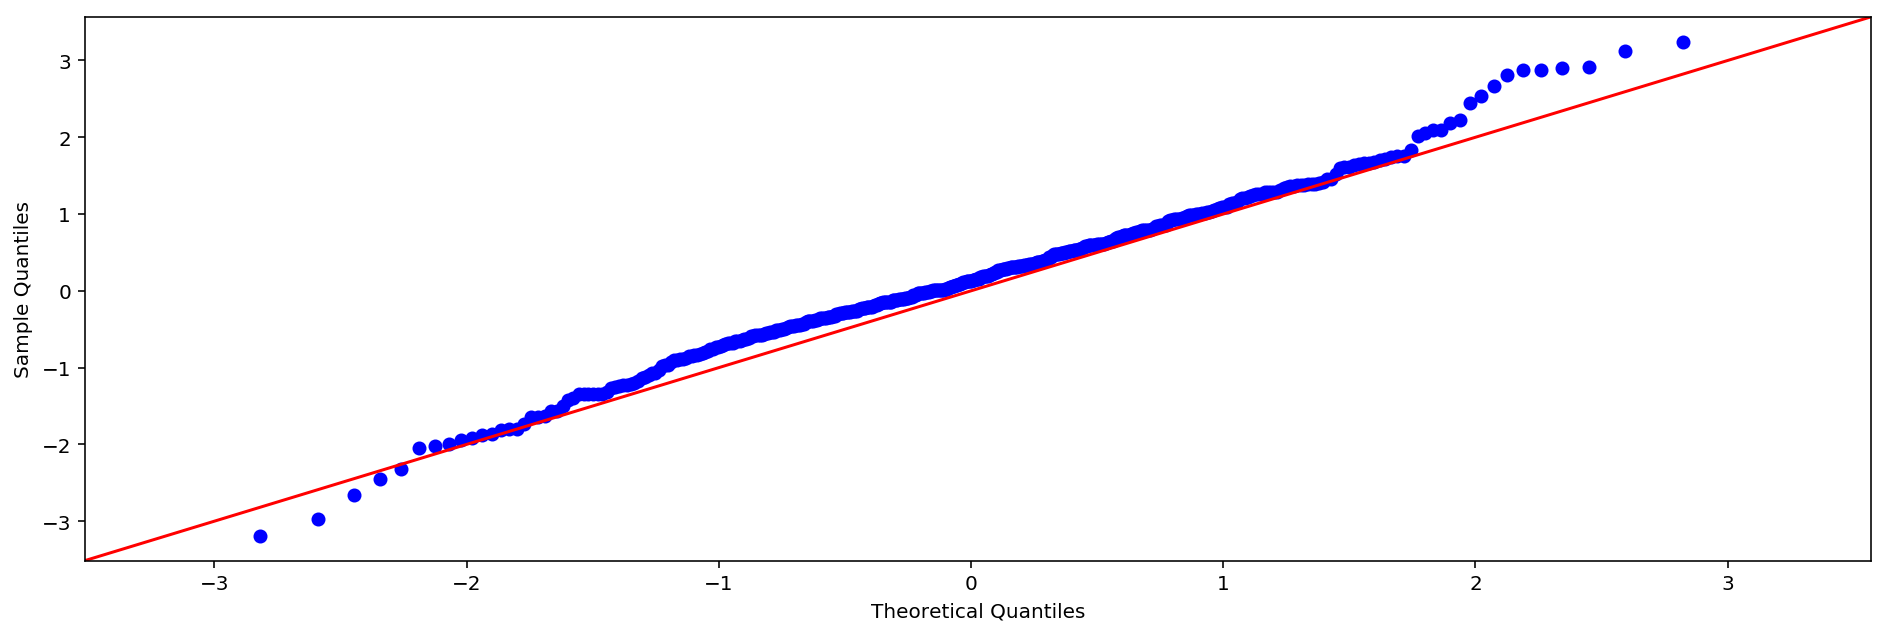

In [45]:
sm.qqplot(b.resid/b.resid.std())
sm.qqline(plt.gca(), '45')

In [46]:
sm.tsa.kpss(b.resid, regression='c')

(0.6050220417232657,
 0.022179814388794027,
 18,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

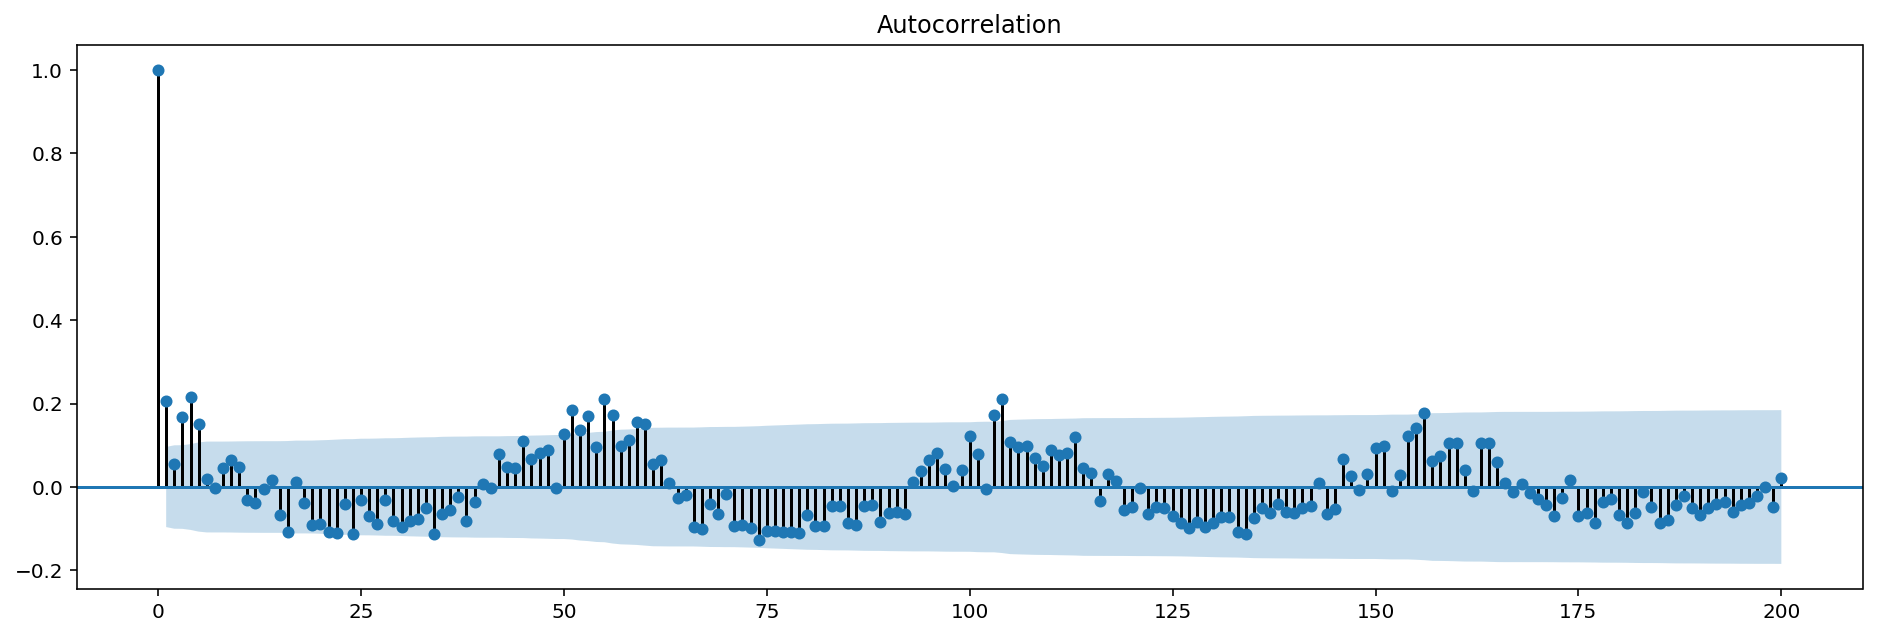

In [47]:
plot_acf(b.resid**2, lags=200);

In [48]:
ima1 = sm.tsa.ARIMA(b.resid,order=(0,1,1)).fit(trend='nc')
arima11 = sm.tsa.ARIMA(b.resid,order=(1,1,1)).fit(trend='nc')
sarima111x011 = sm.tsa.SARIMAX(b.resid,order=(1,1,1), seasonal_order=(0,1,1,52)).fit()

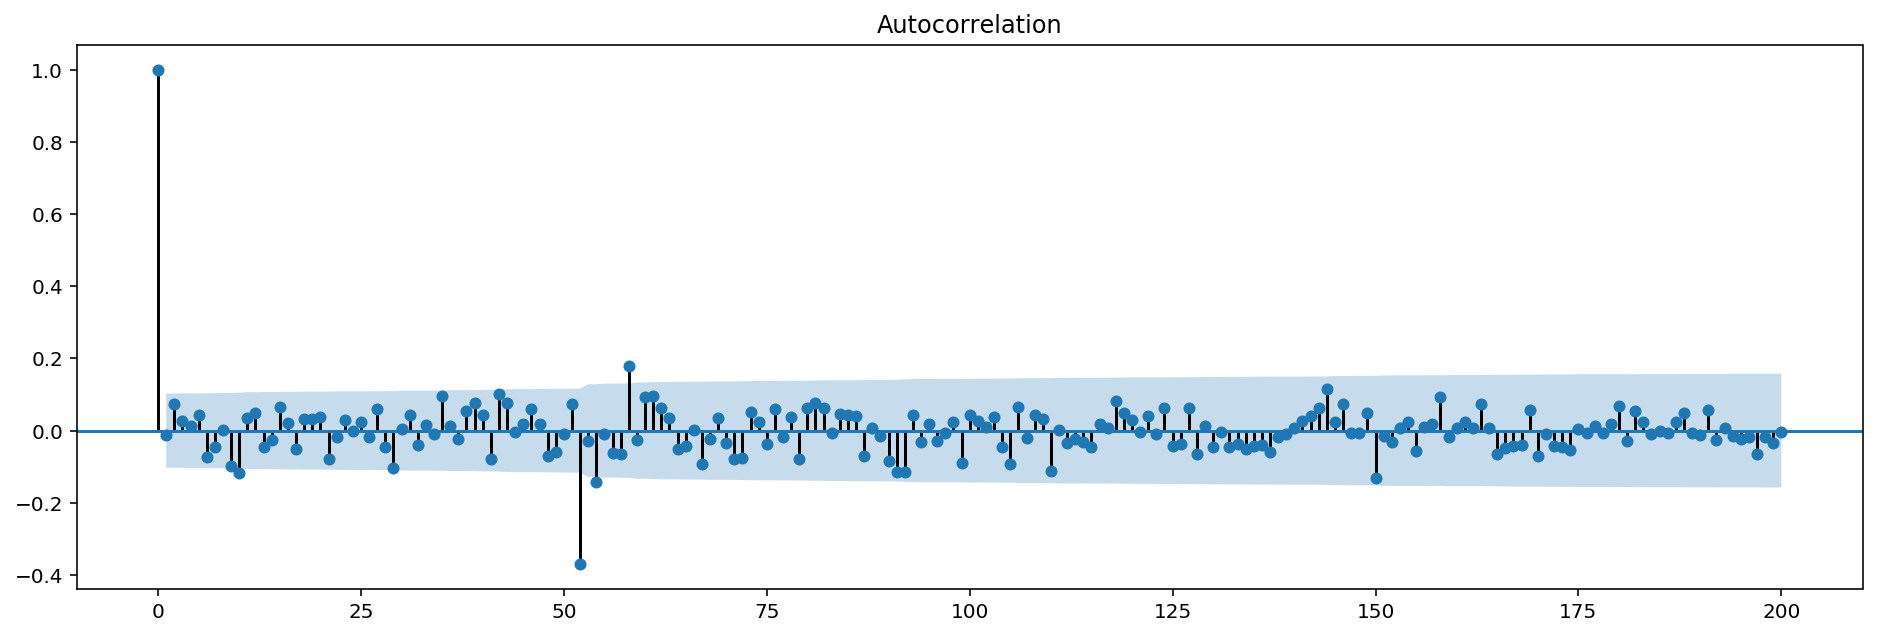

In [49]:
plot_acf(arima11.resid.diff(52).dropna(),lags=200);

In [50]:
sarima111x011.conf_int()

0            1
ar.L1        0.104141     0.265397
ma.L1       -0.990141    -0.925720
ma.S.L52    -0.833353    -0.614510
sigma2    1166.747892  1480.800420

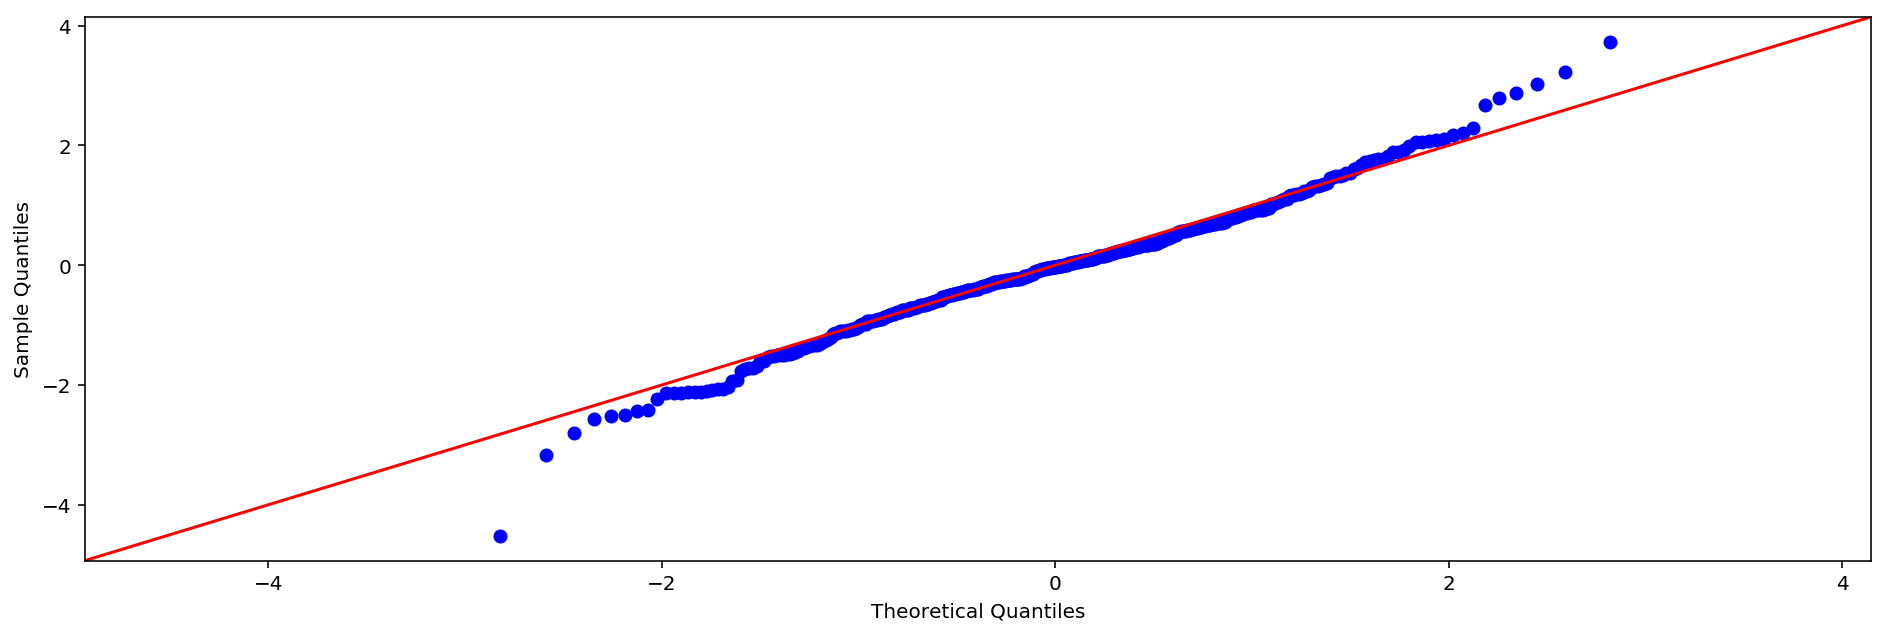

In [51]:
sm.qqplot(sarima111x011.resid/np.sqrt(sarima111x011.params.sigma2));
sm.qqline(plt.gca(),'45')

In [52]:
sarima111x011.aic

3697.9279207792074

In [53]:
ima1.aic

4060.715389289425

In [54]:
arima11.aic

4049.2226009240194

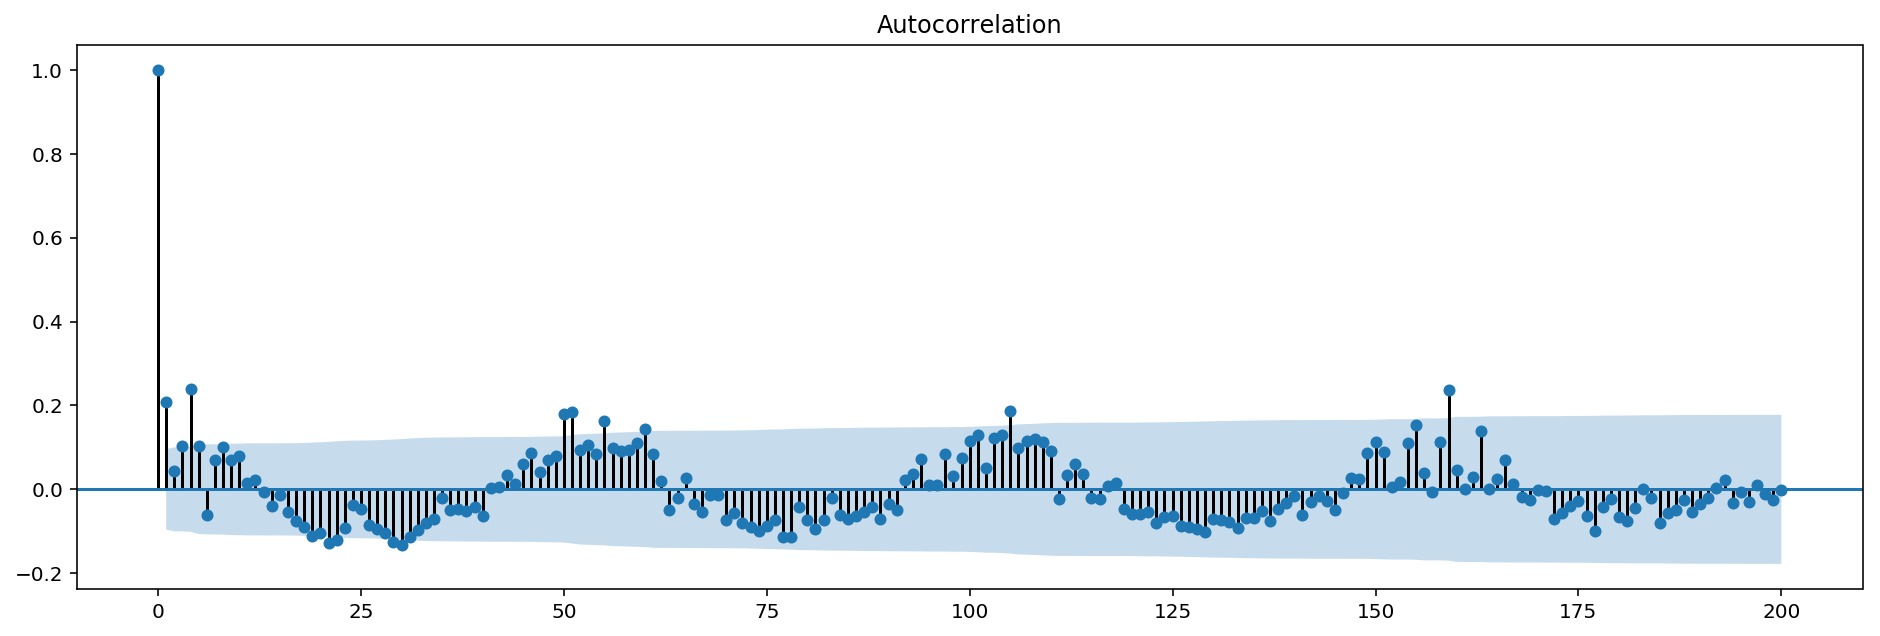

In [55]:
plot_acf(sarima111x011.resid.pow(2), lags=200);

# Trend estimation by fourier decomposition

In [56]:
four_coeff= [(f,phase) for phase in (np.pi/2,0) for f in range(1,10)] #sins dropped because didn't contribute.
                                                                    # higher order than 2 neither
four = np.vstack([np.sin(np.arange(c.index.size)/52.143*2*f*np.pi + phase) for (f, phase) in four_coeff])
four = pd.DataFrame(four.T)
four.index = c.index
four.columns = [f'sin{f}' if phase == 0 else f'cos{f}' for (f,phase) in four_coeff]

In [57]:
c # consumption in GWh
holiday_pop #people days of holiday per week
w #average temperature deviation(?) per week
four #fourier regressors

regressors = pd.DataFrame({'temp':w['CH_temperature'], 'holidays':holiday_pop, 'time':pd.Series(np.arange(len(c)), index=c.index)})
regressors = pd.concat([regressors,four],axis=1)

whf_model = LinearRegression().fit(regressors.values, c.values)
whf_est = pd.Series(data=whf_model.predict(regressors), index=c.index)
whf_resid = c - whf_est

Performs better than stl in term of residual MSE, but some clearly visible seasonal component remains in the residuals in the first and last week of the year, so it doesn't make the data "really" stationary. STL is better in this, even if the residual MSE is bigger

In [58]:
print(
    whf_resid.pow(2).mean(),
    b.resid.pow(2).mean())

759.2160654306153 1091.6734543552973


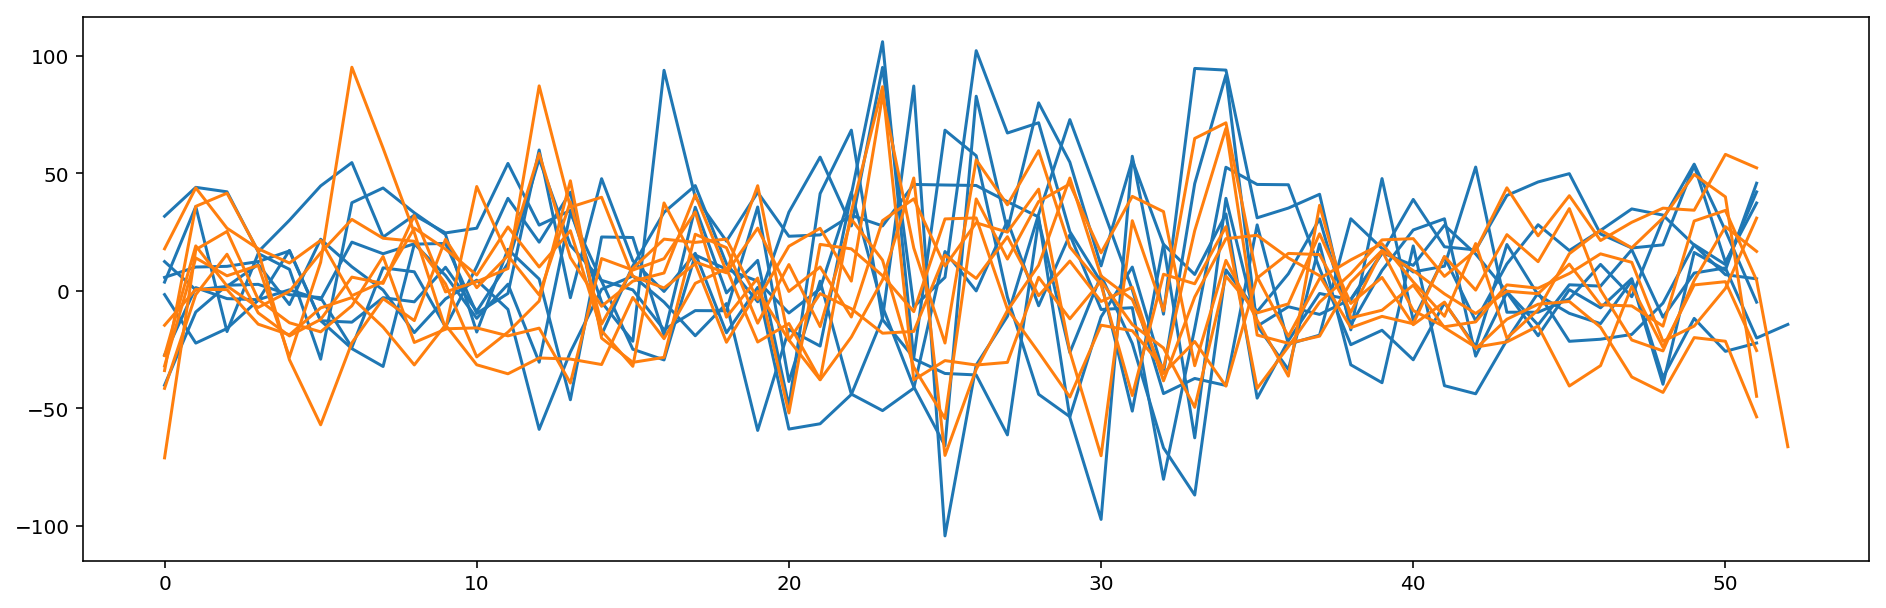

In [59]:
# blue for stl residuals, orange for 
[plt.plot(b.resid[str(year)].values, c='C0') for year in range(2010,2017)];
[plt.plot(whf_resid[str(year)].values, c='C1') for year in range(2010,2017)];

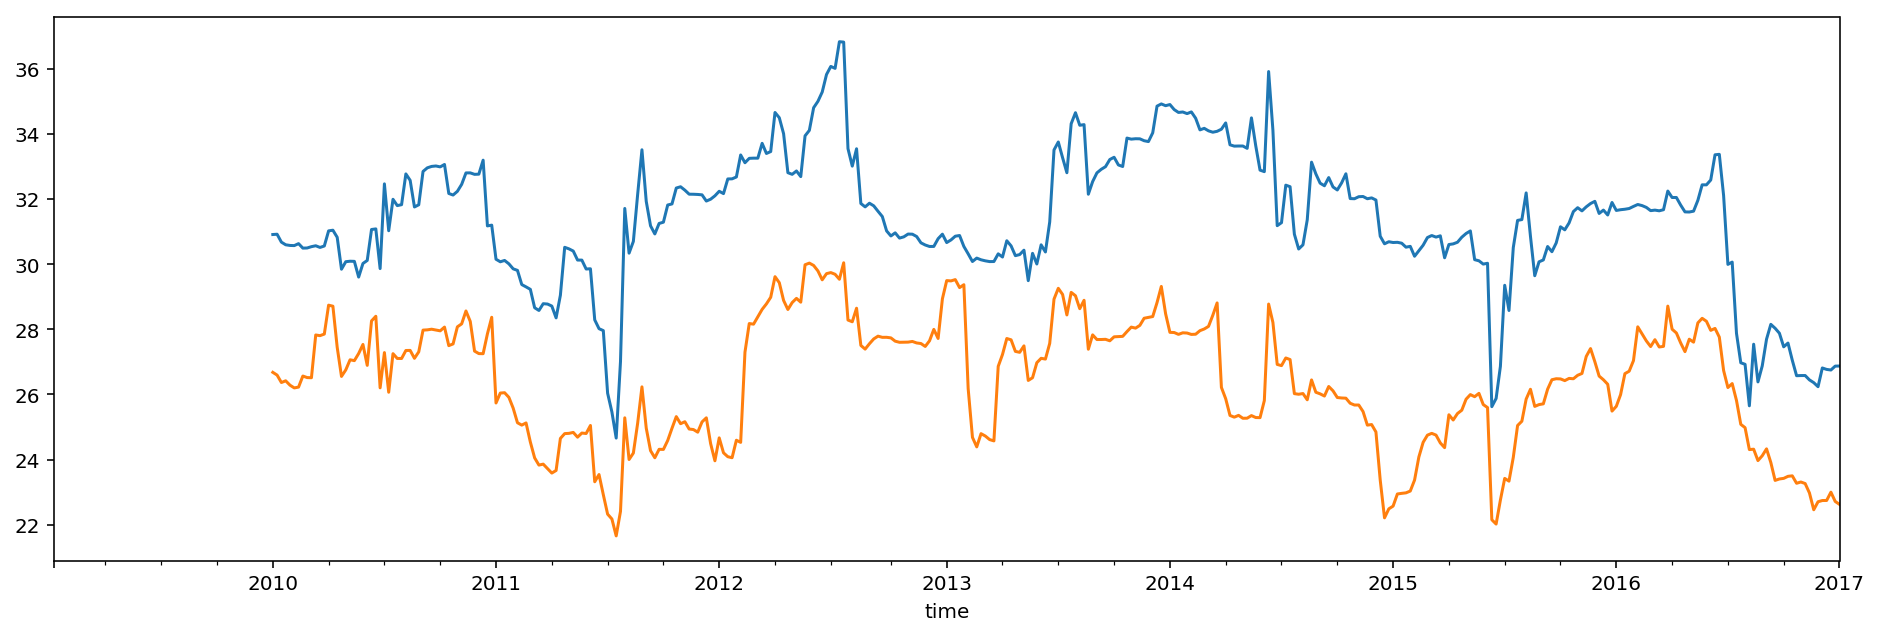

In [60]:
b.resid.rolling(52).std().plot()
whf_resid.rolling(52).std().plot()

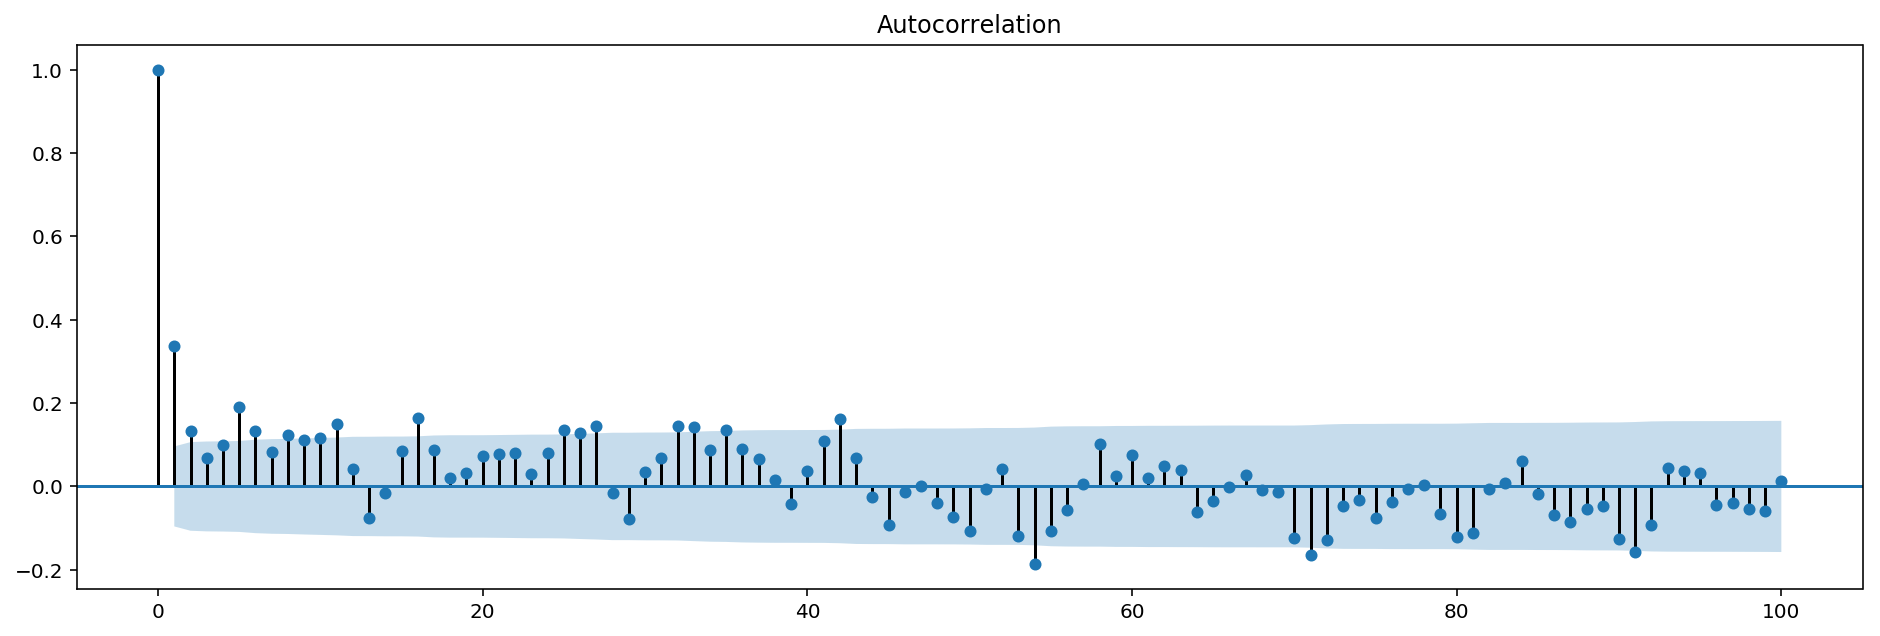

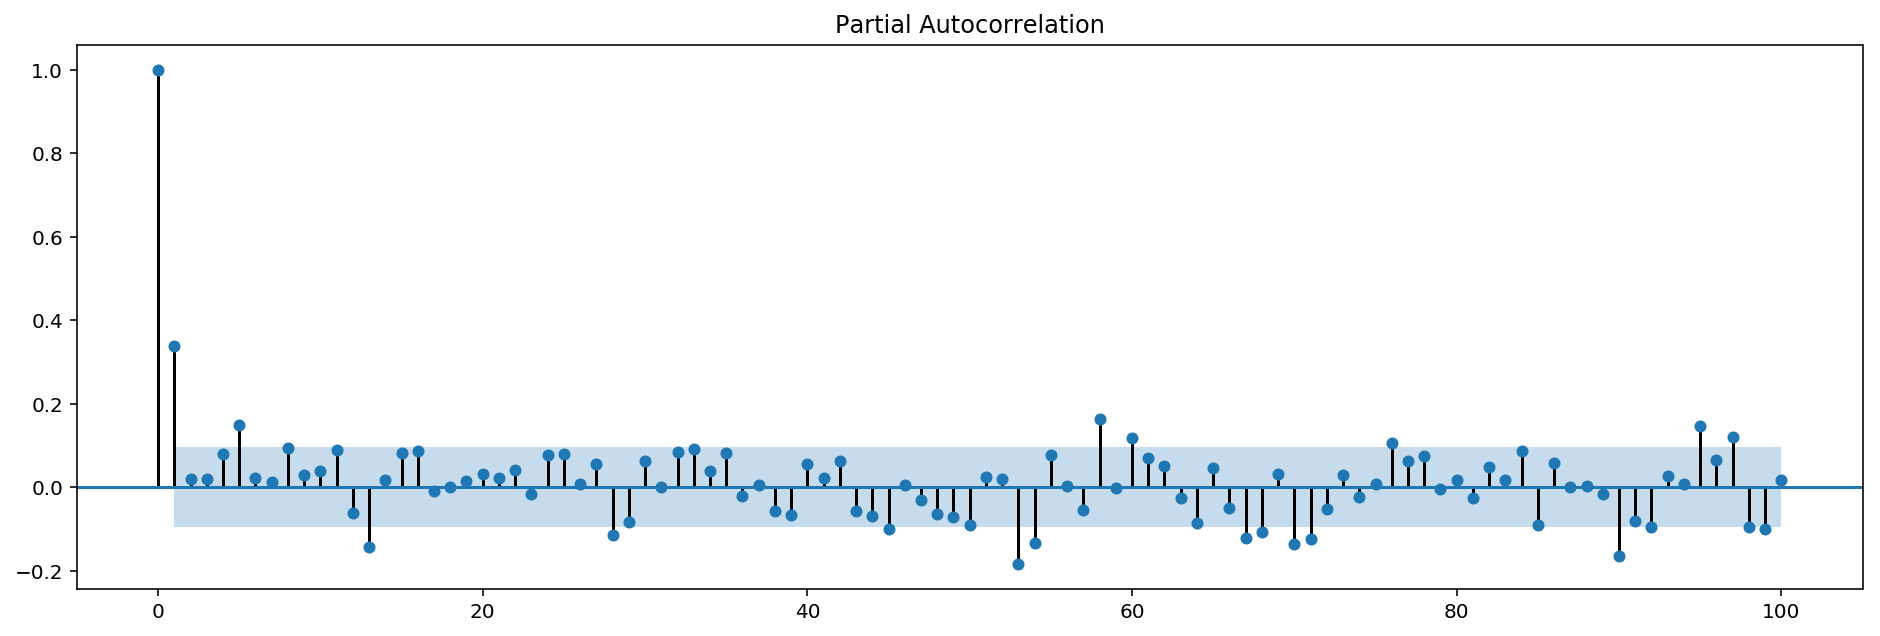

In [61]:
plot_acf(whf_resid,lags=100)
plot_pacf(whf_resid,lags=100);

In [62]:
arma10 = sm.tsa.ARMA(whf_resid,order=(1,0)).fit()
arma10.conf_int()

0         1
const   -3.768283  3.742713
ar.L1.y  0.247711  0.428485

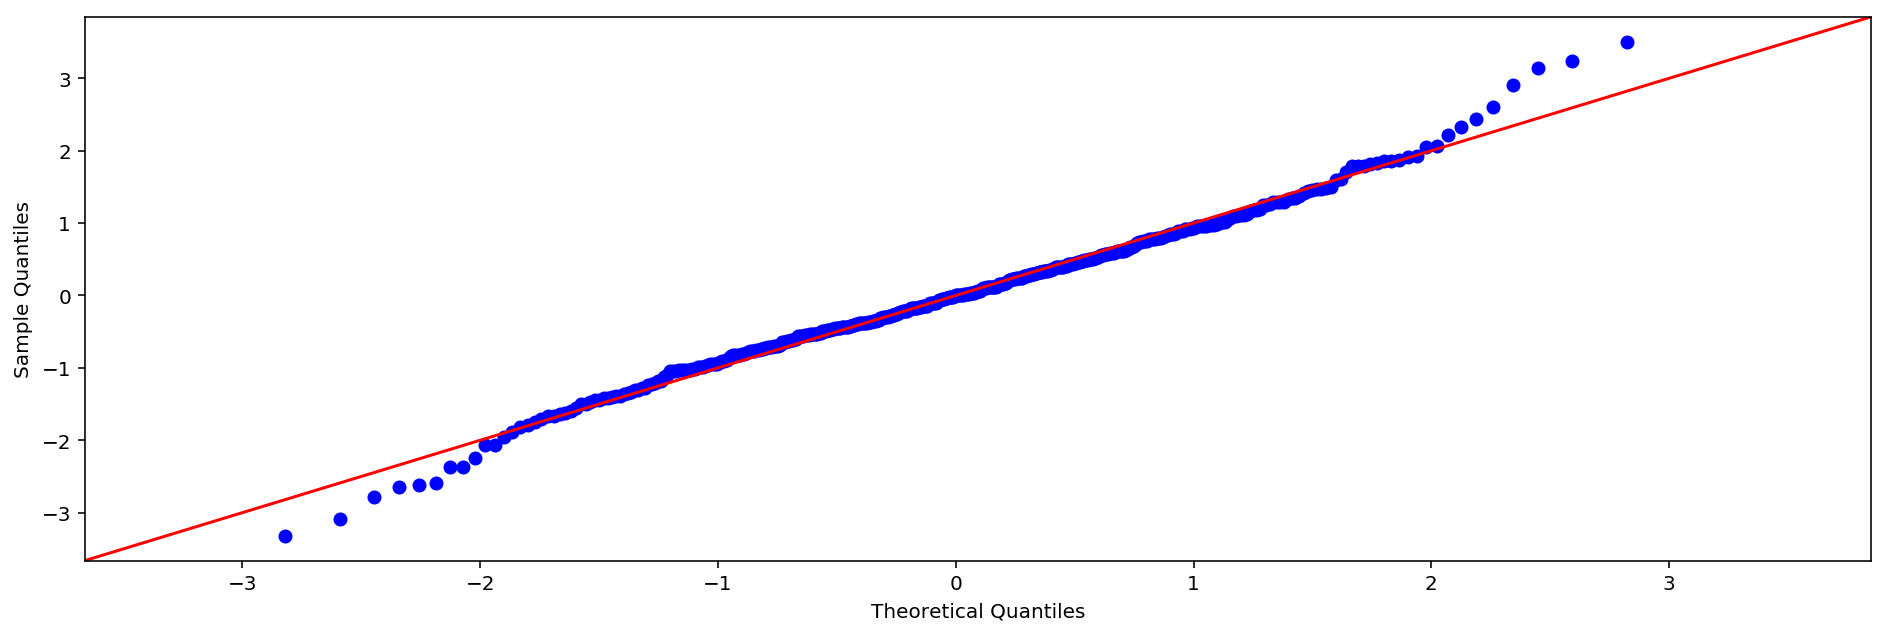

In [63]:
sm.qqplot(arma10.resid/arma10.resid.std());
sm.qqline(plt.gca(),'45')

In [64]:
sm.tsa.kpss(arma10.resid)

/usr/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.17407986394741937,
 0.1,
 18,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

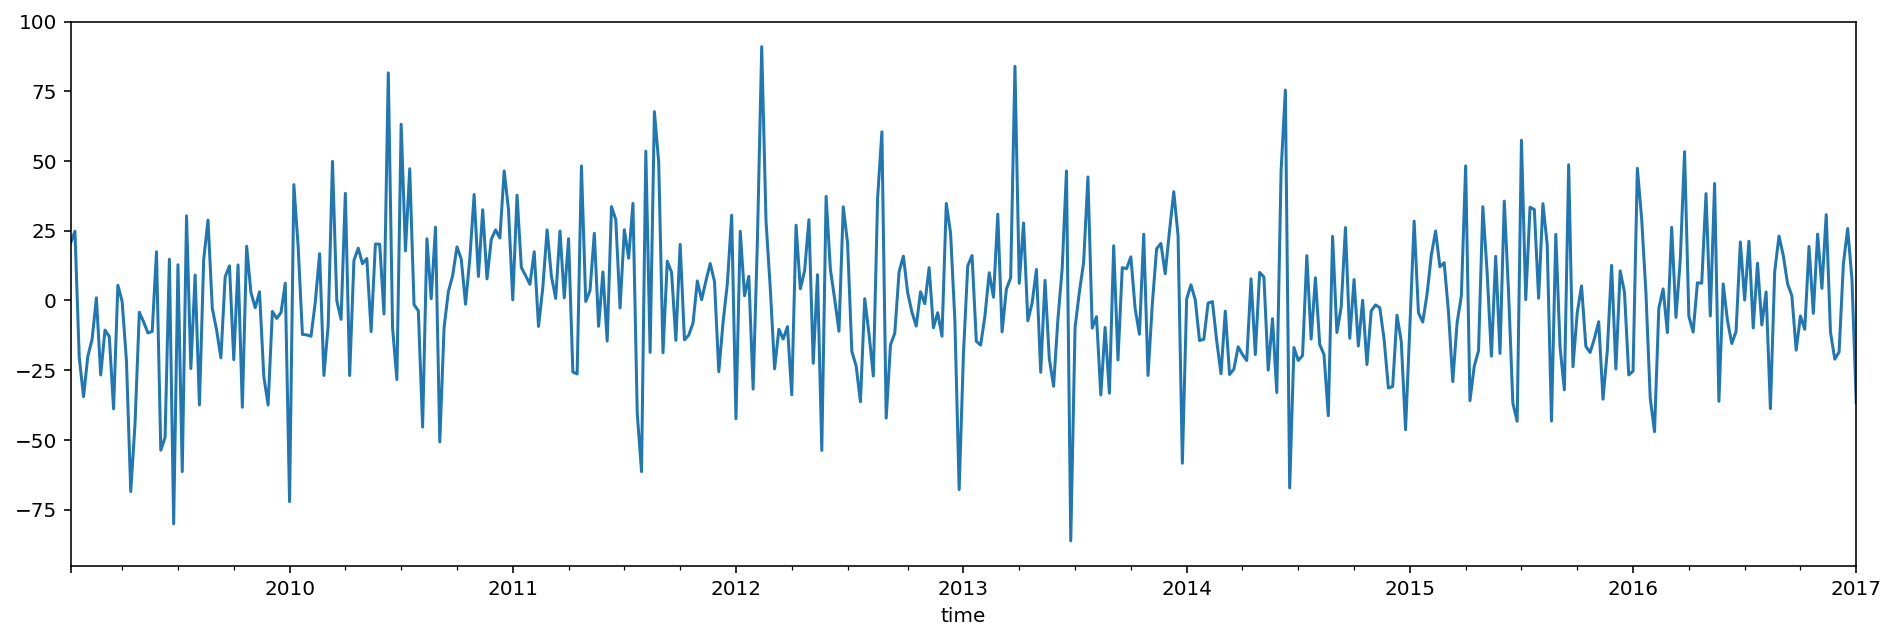

In [65]:
arma10.resid.plot()

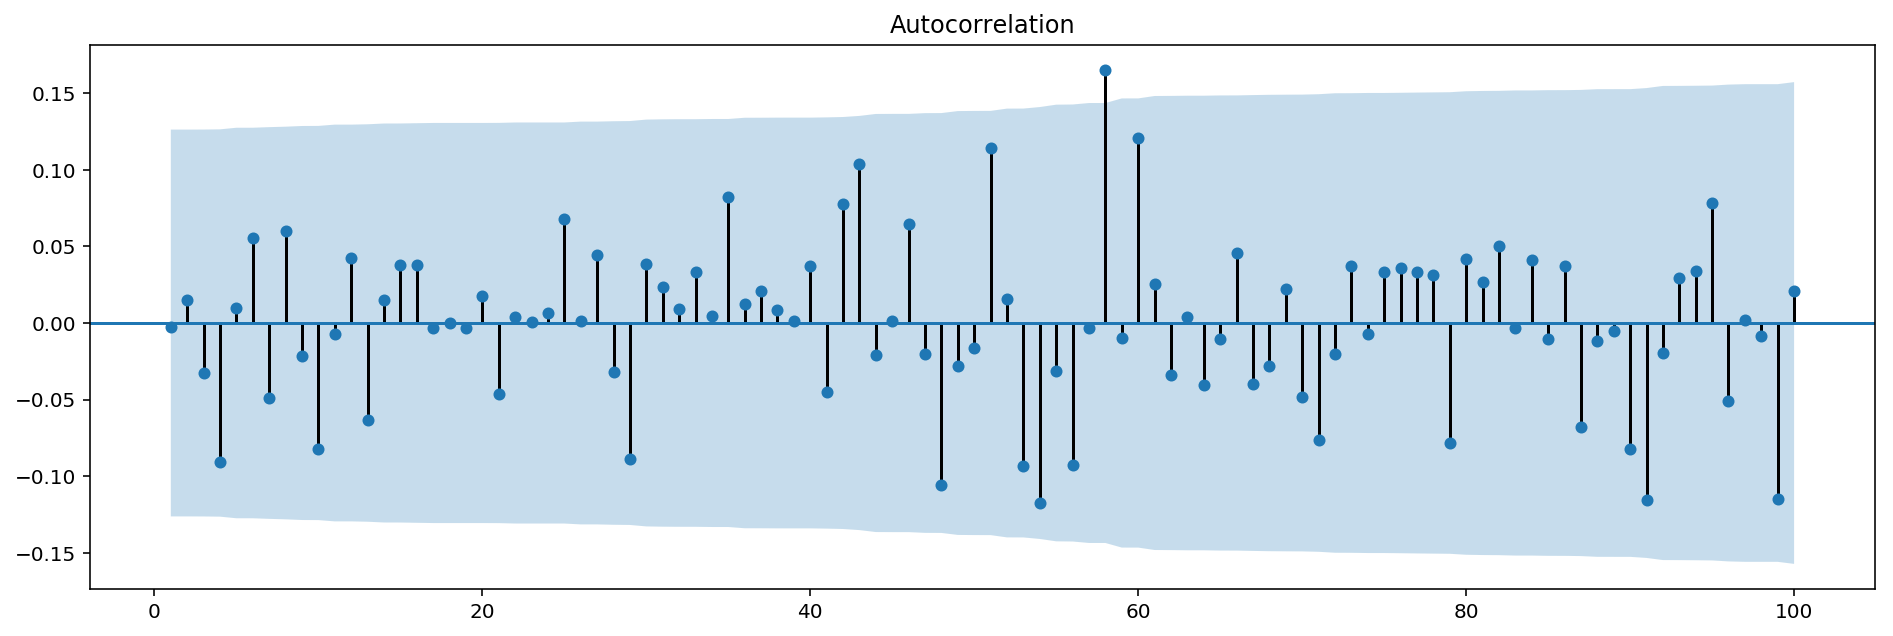

In [121]:
plot_acf(arima11.resid, lags=100, zero=False, alpha=0.01);